<a href="https://colab.research.google.com/github/SaraGhR/hip-fracture-care-episodes/blob/main/hip_fracture_analyzing_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('star.csv')
df.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S356,S357,S358,S359,S360,S361,S362,S363,S364,S365
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0


vitual samples:

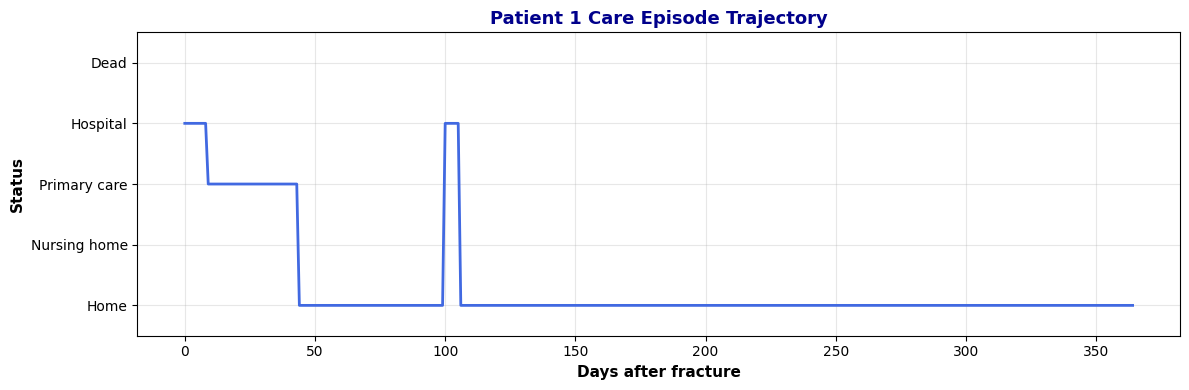

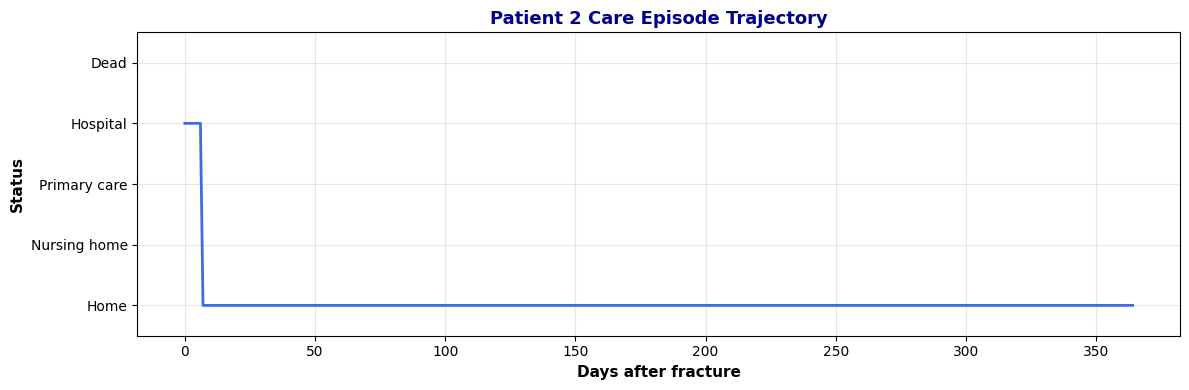

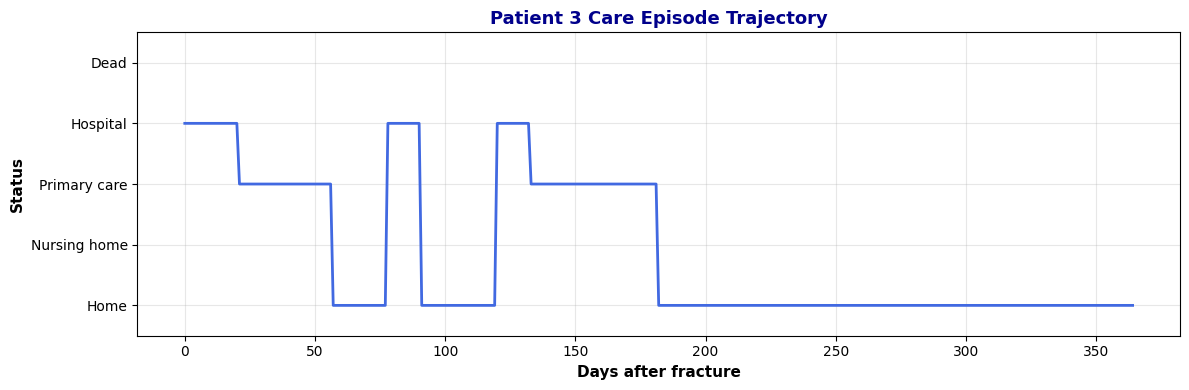

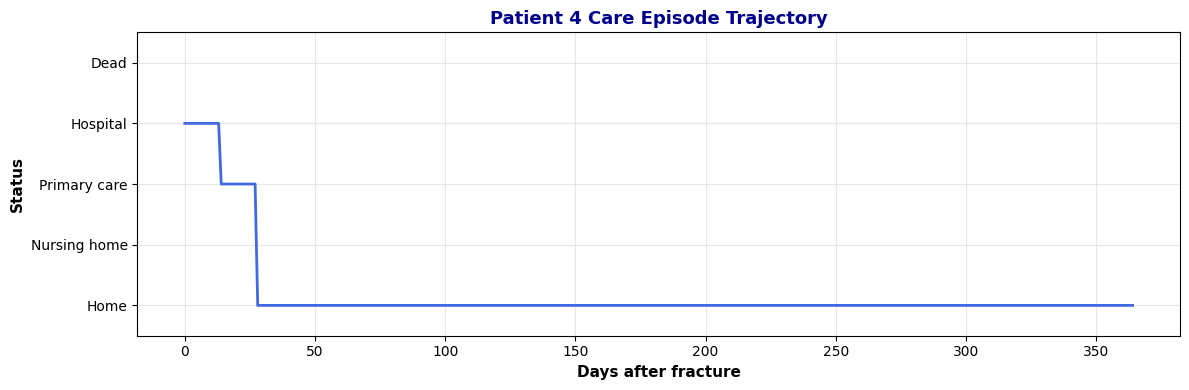

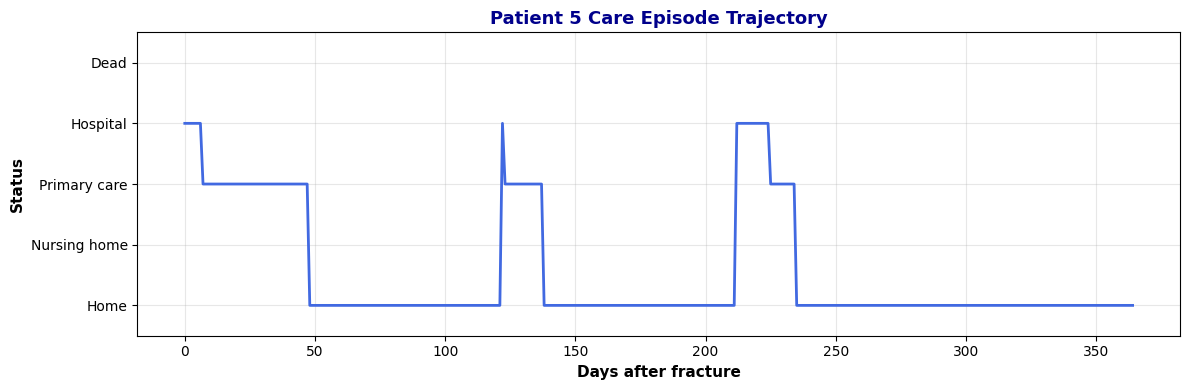

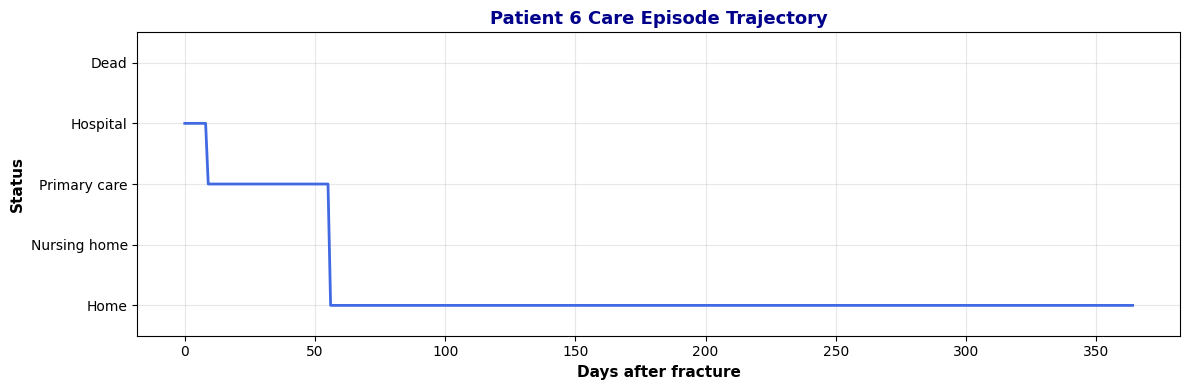

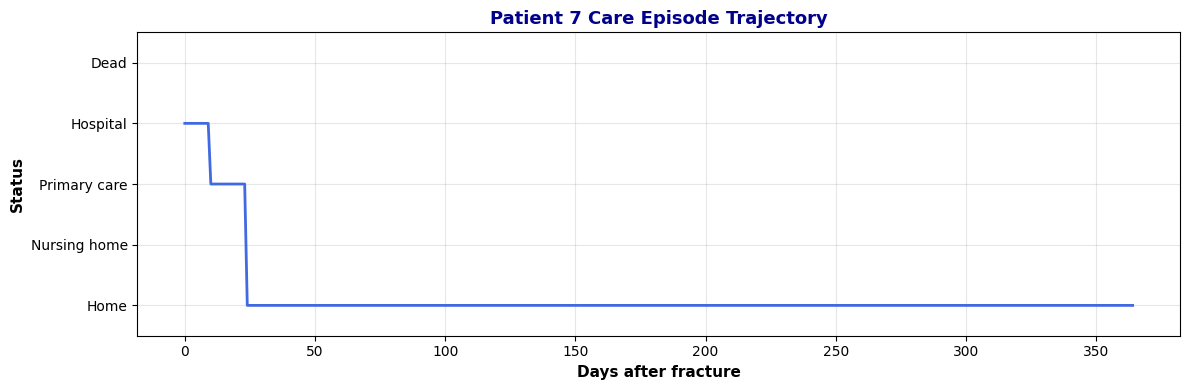

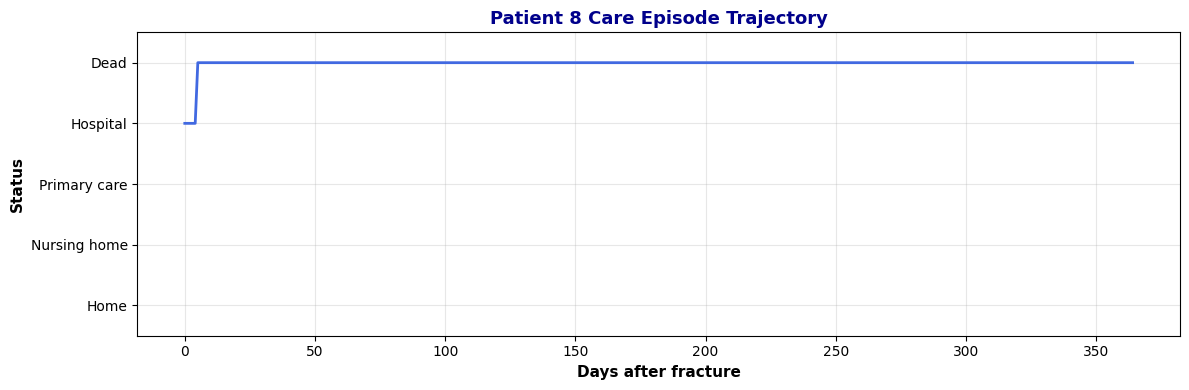

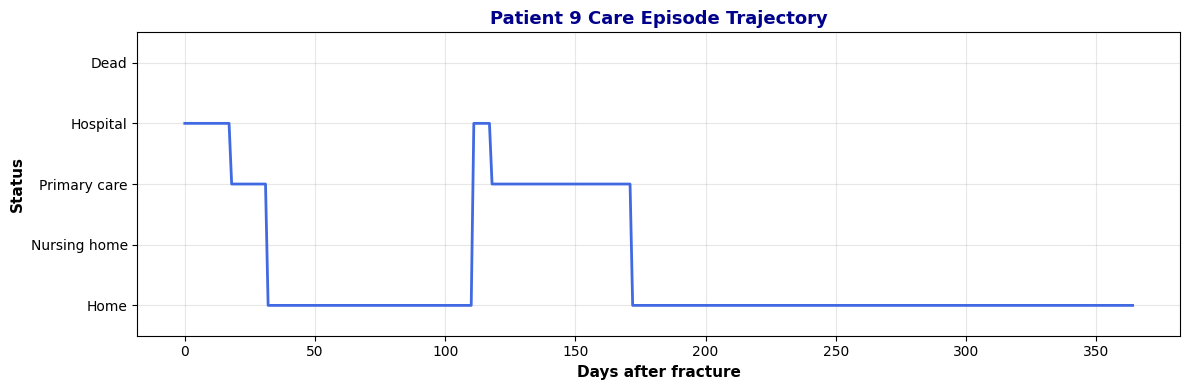

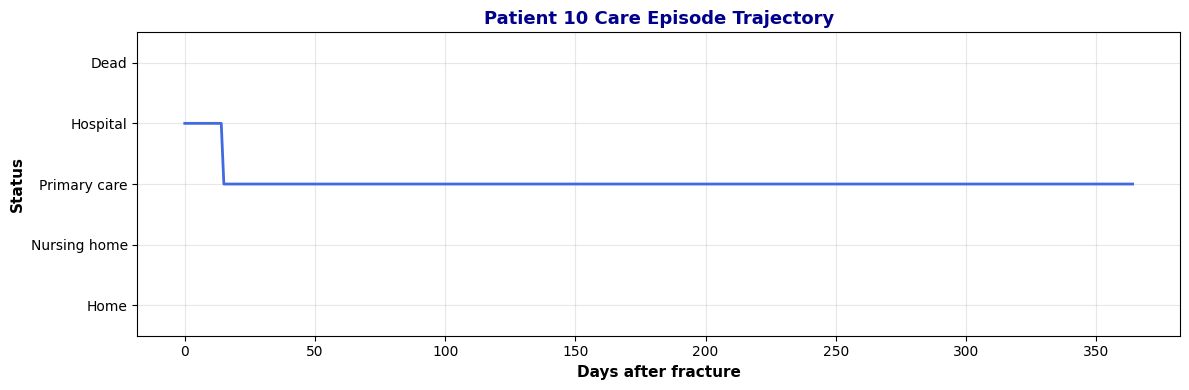

In [ ]:
status_map = {
    0: "Home",
    1: "Nursing home",
    2: "Primary care",
    3: "Hospital",
    4: "Dead"
}


for i in range(0,10):
    patient = df.iloc[i, 1:366]

    plt.figure(figsize=(12, 4))
    plt.plot(patient.values, color="royalblue", linewidth=2)


    plt.ylim(-0.5, 4.5)
    plt.yticks(list(status_map.keys()), list(status_map.values()))
    plt.xlabel("Days after fracture", fontsize=11, fontweight="bold")
    plt.ylabel("Status", fontsize=11, fontweight="bold")
    plt.title(f"Patient {df.iloc[i,0]} Care Episode Trajectory",
              fontsize=13, fontweight="bold", color="darkblue")

    # Style
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


#Clustering

Based on samples, I decided to put them in 4 categories: stable situation, only gets better, only gets worse, unstable situation

In [ ]:
def classify_patient(row):
    values = row.values
    start, end = values[0], values[-1]
    diffs = np.diff(values)

    num_changes = np.sum(diffs != 0)
    ever_worse = np.any(diffs > 0)   # goes worse
    ever_better = np.any(diffs < 0)  # gets better


    if num_changes == 0:
        return "Stable situation"
    elif (not ever_worse) and (end <= start):
        return "Improving Situation"
    elif (not ever_better) and (end >= start):
        return "Declining Situation"
    else:
        return "Fluctuating Situation"

# classification
df["cluster"] = df.drop("ID", axis=1).apply(classify_patient, axis=1)

# outcome
print(df["cluster"].value_counts())
df.head()

cluster
Fluctuating Situation    278
Improving Situation      199
Declining Situation       29
Stable situation          10
Name: count, dtype: int64


,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Improving Situation
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Improving Situation
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation


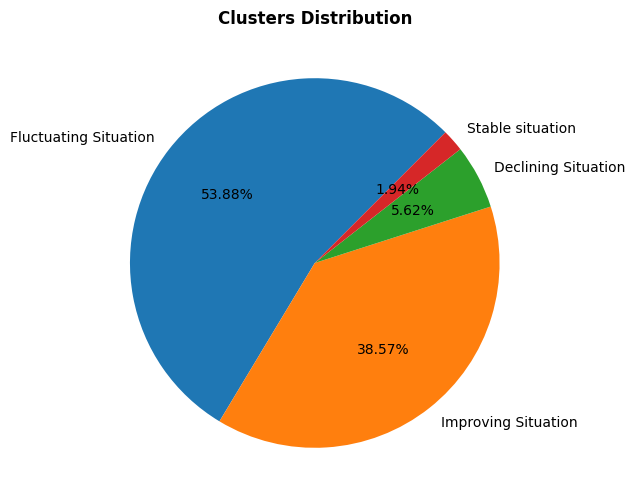

In [ ]:
#Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    df["cluster"].value_counts(),
    labels=df["cluster"].value_counts().index,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Clusters Distribution", fontweight='bold')
plt.show()

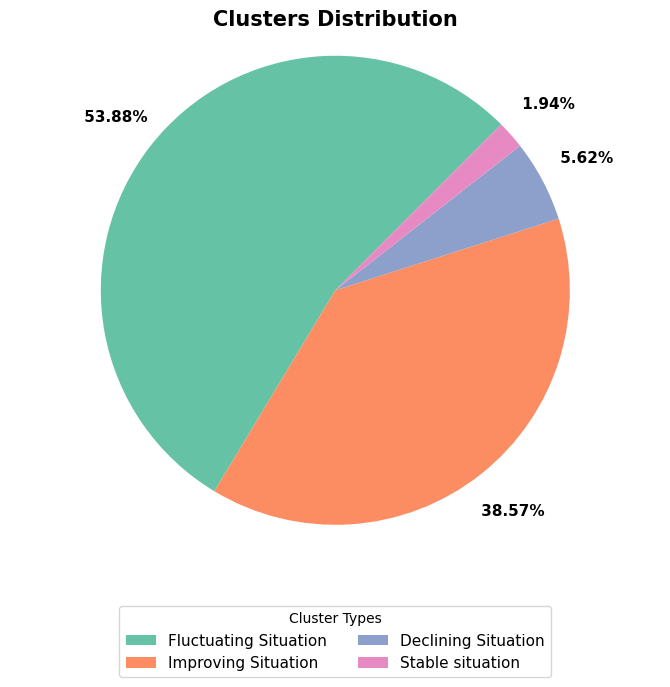

In [ ]:
colors = sns.color_palette("Set2", n_colors=df["cluster"].nunique())


counts = df["cluster"].value_counts()
labels = counts.index
sizes = counts.values


fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    autopct=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15,
)


for i, (wedge, size) in enumerate(zip(wedges, sizes)):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = wedge.r * 1.2 * np.cos(np.deg2rad(ang))
    y = wedge.r * 1.2 * np.sin(np.deg2rad(ang))
    ax.text(
        x, y,
        f" {size/sum(sizes)*100:.2f}%",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )



ax.set_title("Clusters Distribution", fontsize=15, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Cluster Types",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

# Analyzing patients with a stable situation:

In [ ]:
stable_situation = df[df["cluster"]=="Stable situation"]
stable_situation.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
31,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
74,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
88,89,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
130,131,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
140,141,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation


***My takeaway:** After surgery they pass away or have returned home and still alive.*

S1
Pass away    6
Home         4
Name: count, dtype: int64


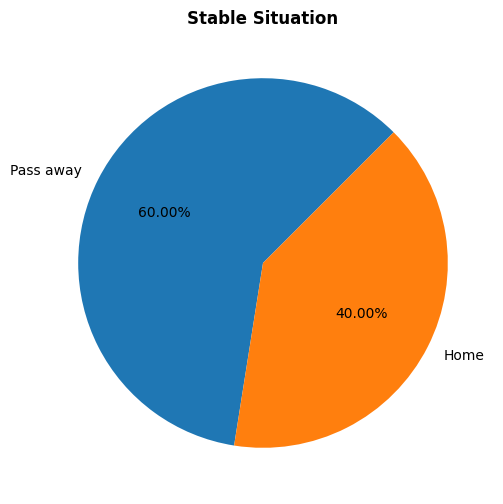

In [ ]:
labels_map = {0: "Home", 4: "Pass away"}
print(stable_situation["S1"].replace(labels_map).value_counts())

#Pie chart
plt.figure(figsize=(6,6))

plt.pie(
    stable_situation["S1"].value_counts(),
    labels=["Home" if x == 0 else "Pass away" for x in stable_situation["S1"].value_counts().index],
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Stable Situation", fontweight='bold')
plt.show()

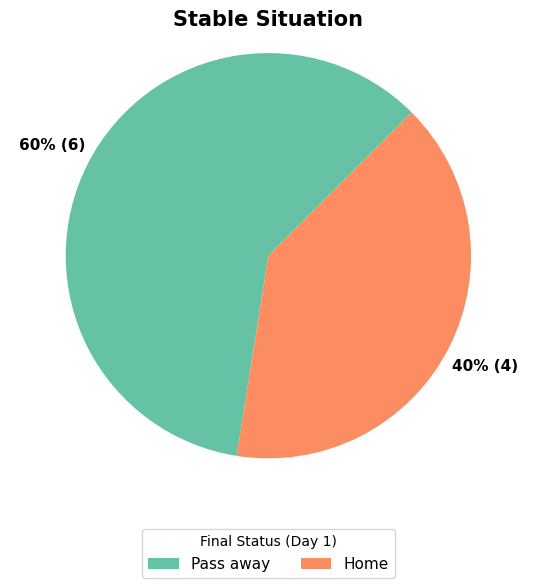

In [ ]:
colors = sns.color_palette("Set2", n_colors=2)


counts = stable_situation["S1"].value_counts()
labels_map = {0: "Home", 4: "Pass away"}
labels = [labels_map[x] for x in counts.index]
sizes = counts.values


fig, ax = plt.subplots(figsize=(6,6))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)


for wedge, size in zip(wedges, sizes):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.2
    y = np.sin(np.deg2rad(ang)) * 1.2
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.0f}% ({size})",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )


ax.set_title("Stable Situation", fontsize=15, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Final Status (Day 1)",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

The overall probability of get back at home without any problems or death after the surgery:

In [ ]:
labels_map = {0: "home", 4: "Pass away"}
print((stable_situation["S1"].replace(labels_map).value_counts()) / (df.shape[0]-1)*100)

S1
Pass away    1.165049
home         0.776699
Name: count, dtype: float64


To find out how many of the patients who get back home after surgery would have a stable situation during a year:

In [ ]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

stable_counts = stable_situation["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

stable_home = stable_counts.get("home", 0)
all_home = all_counts.get("home", 0)

percentage = (stable_home / all_home * 100)

print(f"Patients in stable situation back home in Day 1: {stable_home}")
print(f"All patients back home in Day 1: {all_home}")
print(f"Percentage: {percentage:.2f}%")

Patients in stable situation back home in Day 1: 4
All patients back home in Day 1: 9
Percentage: 44.44%


***My takeaway:** It's barely happened that a patient gets back home after surgery, and more than 50% of these situations would be changed, so I think it's better to keep them in stage 1: "nursing home" rather than staying in the home for at least ? days*

In [ ]:
df[df["S1"]==0]["cluster"].value_counts()

,count
cluster,
Fluctuating Situation,5
Stable situation,4


In [ ]:
df[(df["S1"] == 0) & (df["cluster"] == "Fluctuating Situation")]

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
59,60,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
105,106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
108,109,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
162,163,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
371,372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation


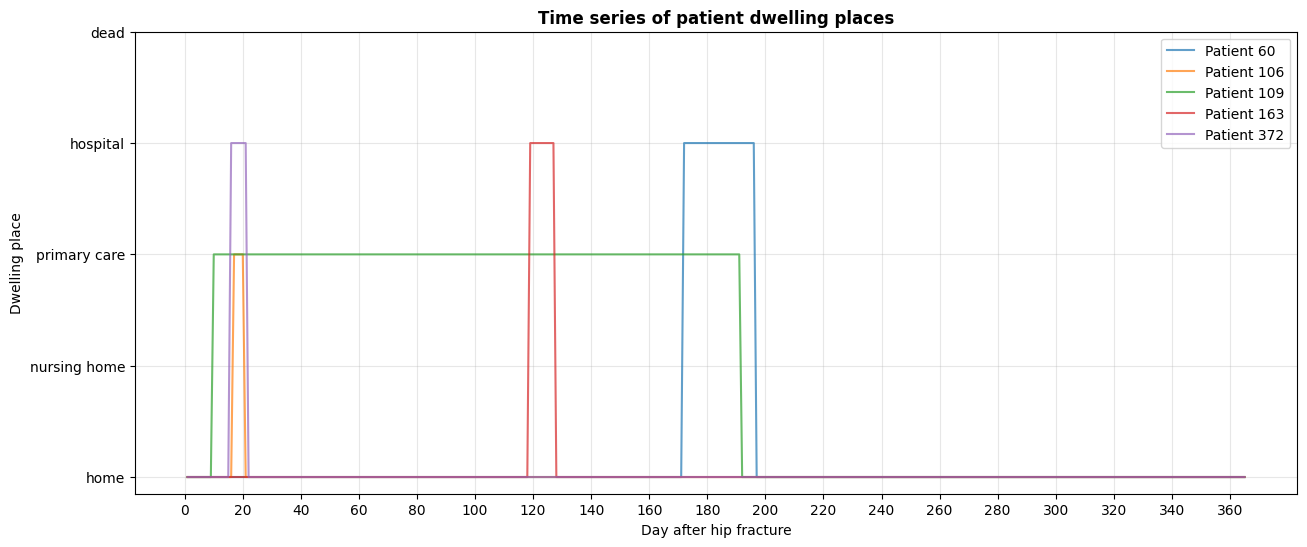

In [ ]:
subset = df[(df["S1"] == 0) & (df["cluster"] == "Fluctuating Situation")]

plt.figure(figsize=(15,6))

for idx, row in subset.iterrows():
    values = row.drop(["ID", "cluster"]).values
    plt.plot(range(1, 366), values, alpha=0.7, label=f"Patient {row['ID']}")

plt.xlabel("Day after hip fracture")
plt.ylabel("Dwelling place")
plt.title("Time series of patient dwelling places", fontweight='bold')

plt.yticks([0,1,2,3,4], ["home","nursing home","primary care","hospital","dead"])
plt.xticks(np.arange(0, 366, 20))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### **Main Results:** It's barely happened that a patient gets back home after surgery, and more than 50% of these situations would be changed, so I think it's better to keep them in stage 1: "nursing home" rather than let them back to home for at least 2 weeks, cause I think most things show up in week 1 and 2, but now we see the result as a stage-changing in week 3.

# Analyzing patients who only gets worse:

In [ ]:
OGW = df[df["cluster"]=="Declining Situation"]
OGW.shape

(29, 367)

How many pass away:

In [ ]:
print("Total patients in declining situation in Day 1: ", OGW.shape[0])
print("home: ", OGW[OGW["S1"]==0].shape[0])
print("nursing home: ", OGW[OGW["S1"]==1].shape[0])
print("primary care facility: ", OGW[OGW["S1"]==2].shape[0])
print("hospital: ", OGW[OGW["S1"]==3].shape[0])

Total patients in declining situation in Day 1:  29
home:  0
nursing home:  0
primary care facility:  1
hospital:  28


In [ ]:
print("Total patients in declining situation in Day 365: ", OGW.shape[0])
print("home: ", OGW[OGW["S365"]==0].shape[0])
print("nursing home: ", OGW[OGW["S365"]==1].shape[0])
print("primary care facility: ", OGW[OGW["S365"]==2].shape[0])
print("hospital: ", OGW[OGW["S365"]==3].shape[0])
print("Pass away: ", OGW[OGW["S365"]==4].shape[0])

Total patients in declining situation in Day 365:  29
home:  0
nursing home:  0
primary care facility:  0
hospital:  0
Pass away:  29


***My takeaway:** So, all the patients in this category pass away in first year.*

How many jumps happened and when:

In [ ]:
# get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs > 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])


jump_info_OGW = OGW.drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)
jump_info_OGW.head()

,num_jumps,jump_days
7,1,[6]
28,1,[2]
30,1,[17]
40,1,[3]
42,1,[17]


In [ ]:
print(jump_info_OGW["num_jumps"].value_counts())

num_jumps
1    29
Name: count, dtype: int64


***My takeaway:** It shows that they all died by 1 change in their situations.*

In [ ]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

OGW_counts = OGW["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

OGW_hospital = OGW_counts.get("hospital", 0)
all_hospital = all_counts.get("hospital", 0)

percentage = (OGW_hospital / all_hospital * 100)

print(f"Hospitalized patients through Declining Situation in Day 1: {OGW_hospital}")
print(f"Hospitalized patients day through all patients in Day 1: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Hospitalized patients through Declining Situation in Day 1: 28
Hospitalized patients day through all patients in Day 1: 493
Percentage: 5.68%


In [ ]:
df[df["S1"]==3]["cluster"].value_counts()

,count
cluster,
Fluctuating Situation,266
Improving Situation,199
Declining Situation,28


In %:

In [ ]:
(df[df["S1"]==3]["cluster"].value_counts()/ (df[df["S1"]==3]["cluster"].value_counts().sum())*100).round(2)

,count
cluster,
Fluctuating Situation,53.96
Improving Situation,40.37
Declining Situation,5.68


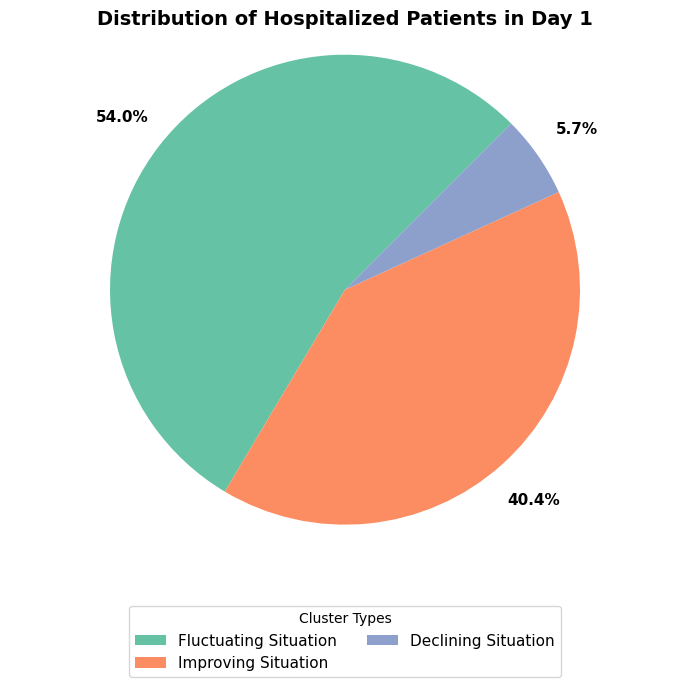

In [ ]:
subset = df[df["S1"] == 3]["cluster"].value_counts()
sizes = subset.values
labels = subset.index


colors = sns.color_palette("Set2", n_colors=len(labels))

# Pie
fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)


for wedge, size in zip(wedges, sizes):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.2
    y = np.sin(np.deg2rad(ang)) * 1.2
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.1f}%",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )


ax.set_title("Distribution of Hospitalized Patients in Day 1",
             fontsize=14, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Cluster Types",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

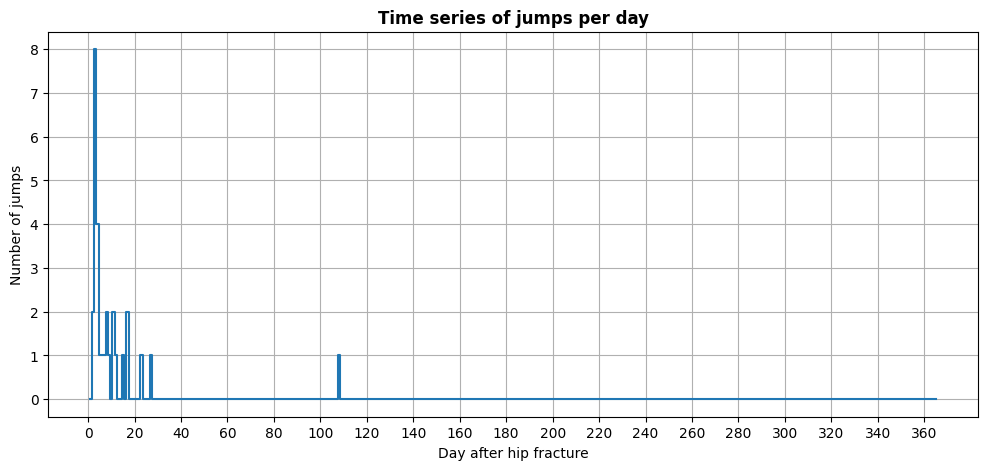

In [ ]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_OGW["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 20)
plt.xticks(xticks)

plt.grid(True)
plt.show()


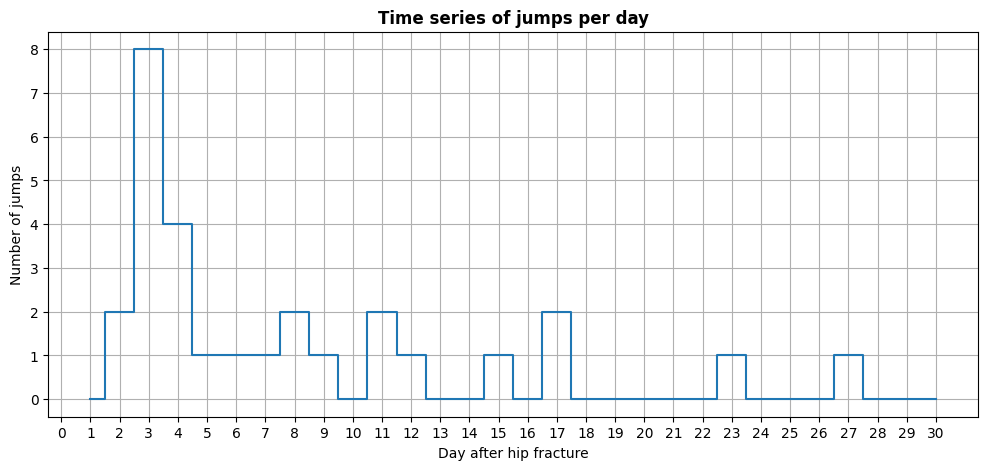

In [ ]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_OGW["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 31)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 1)
plt.xticks(xticks)

plt.grid(True)
plt.show()


#### **Main Result:** In the "Declining Situation" category, which is 5.6% of our patients, they would die mostly during the first month, especially in week 1



# Analyzing patients who only gets better:

In [ ]:
OGB = df[df["cluster"]=="Improving Situation"]
OGB.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Improving Situation
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Improving Situation
5,6,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Improving Situation
6,7,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Improving Situation
9,10,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,Improving Situation


Patients stage in Day 1:

In [ ]:
print("Total patients in Improving Situation in Day 1: ", OGB.shape[0])
print("home: ", OGB[OGB["S1"]==0].shape[0])
print("nursing home: ", OGB[OGB["S1"]==1].shape[0])
print("primary care facility: ", OGB[OGB["S1"]==2].shape[0])
print("hospital: ", OGB[OGB["S1"]==3].shape[0])

Total patients in Improving Situation in Day 1:  199
home:  0
nursing home:  0
primary care facility:  0
hospital:  199


***My takeaway:** patients who "only get better" all got hospitalized on day 1.*

How many patients got hospitalized on day 1 / what percentage % of them are in the OGB category?

In [ ]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

OGB_counts = OGB["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

OGB_hospital = OGB_counts.get("hospital", 0)
all_hospital = all_counts.get("hospital", 0)

percentage = (OGB_hospital / all_hospital * 100)

print(f"Hospitalized in first day through only get worse group: {OGB_hospital}")
print(f"Hospitalized in first day through all patients: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Hospitalized in first day through only get worse group: 199
Hospitalized in first day through all patients: 493
Percentage: 40.37%


In [ ]:
df[df["S1"]==3]["cluster"].value_counts()

,count
cluster,
Fluctuating Situation,266
Improving Situation,199
Declining Situation,28


***My takeaway:** Hospitalization might have a role in improving the patient's situation.*

Patients stage in Day 365:

In [ ]:
print("Total patients in Improving Situation in Day 365: ", OGB.shape[0])
print("home: ", OGB[OGB["S365"]==0].shape[0])
print("nursing home: ", OGB[OGB["S365"]==1].shape[0])
print("primary care facility: ", OGB[OGB["S365"]==2].shape[0])
print("hospital: ", OGB[OGB["S365"]==3].shape[0])

Total patients in Improving Situation in Day 365:  199
home:  141
nursing home:  31
primary care facility:  27
hospital:  0


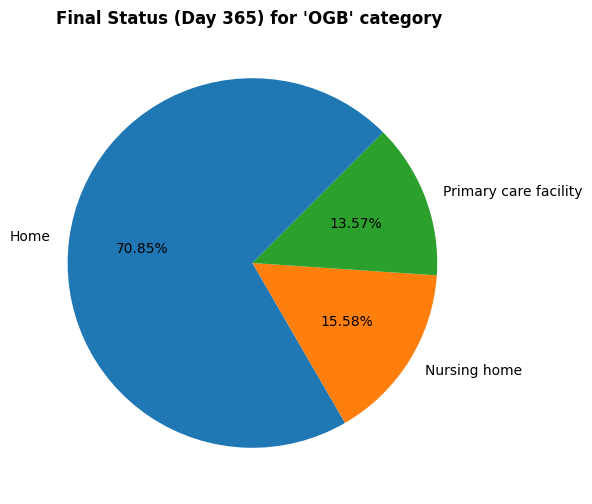

In [ ]:
#pie chart
labels = ["Home", "Nursing home", "Primary care facility"]
sizes = [
    OGB[OGB["S365"]==0].shape[0],
    OGB[OGB["S365"]==1].shape[0],
    OGB[OGB["S365"]==2].shape[0]
]


plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Final Status (Day 365) for 'OGB' category ", fontweight='bold')
plt.show()

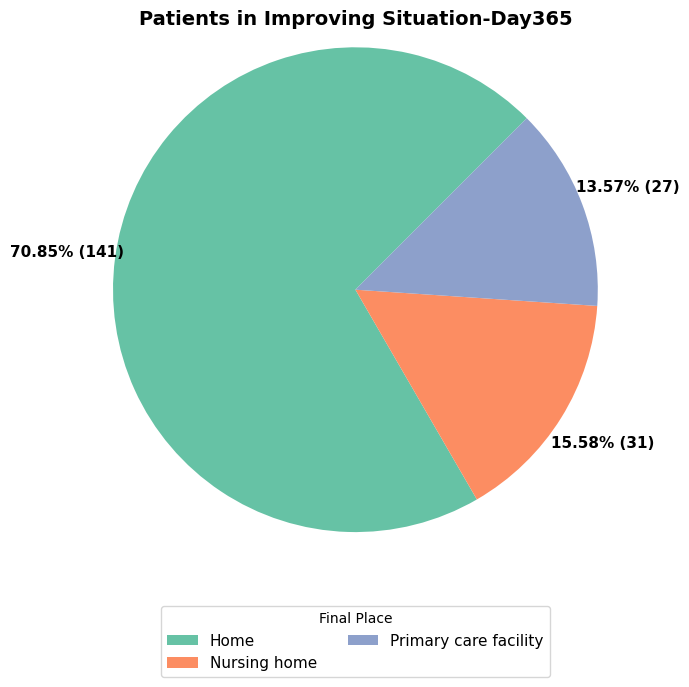

In [ ]:
# Data
labels = ["Home", "Nursing home", "Primary care facility"]
sizes = [
    OGB[OGB["S365"]==0].shape[0],
    OGB[OGB["S365"]==1].shape[0],
    OGB[OGB["S365"]==2].shape[0]
]

colors = sns.color_palette("Set2", n_colors=len(labels))

# Pie chart
fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)


for wedge, size in zip(wedges, sizes):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.2
    y = np.sin(np.deg2rad(ang)) * 1.2
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.2f}% ({size})",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )


ax.set_title("Patients in Improving Situation-Day365",
             fontsize=14, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Final Place",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

How many times jump and when




In [ ]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info_OGB = OGB[OGB["S365"]==0].drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info_OGB.head()

,num_jumps,jump_days
1,1,[8]
3,2,"[15, 29]"
5,2,"[10, 57]"
6,2,"[11, 25]"
14,2,"[10, 43]"


In [ ]:
print(jump_info_OGB["num_jumps"].value_counts())

num_jumps
1    80
2    59
3     2
Name: count, dtype: int64


***My takeaway:** I consider patients who get better by 3 changes in their situation as outliers.

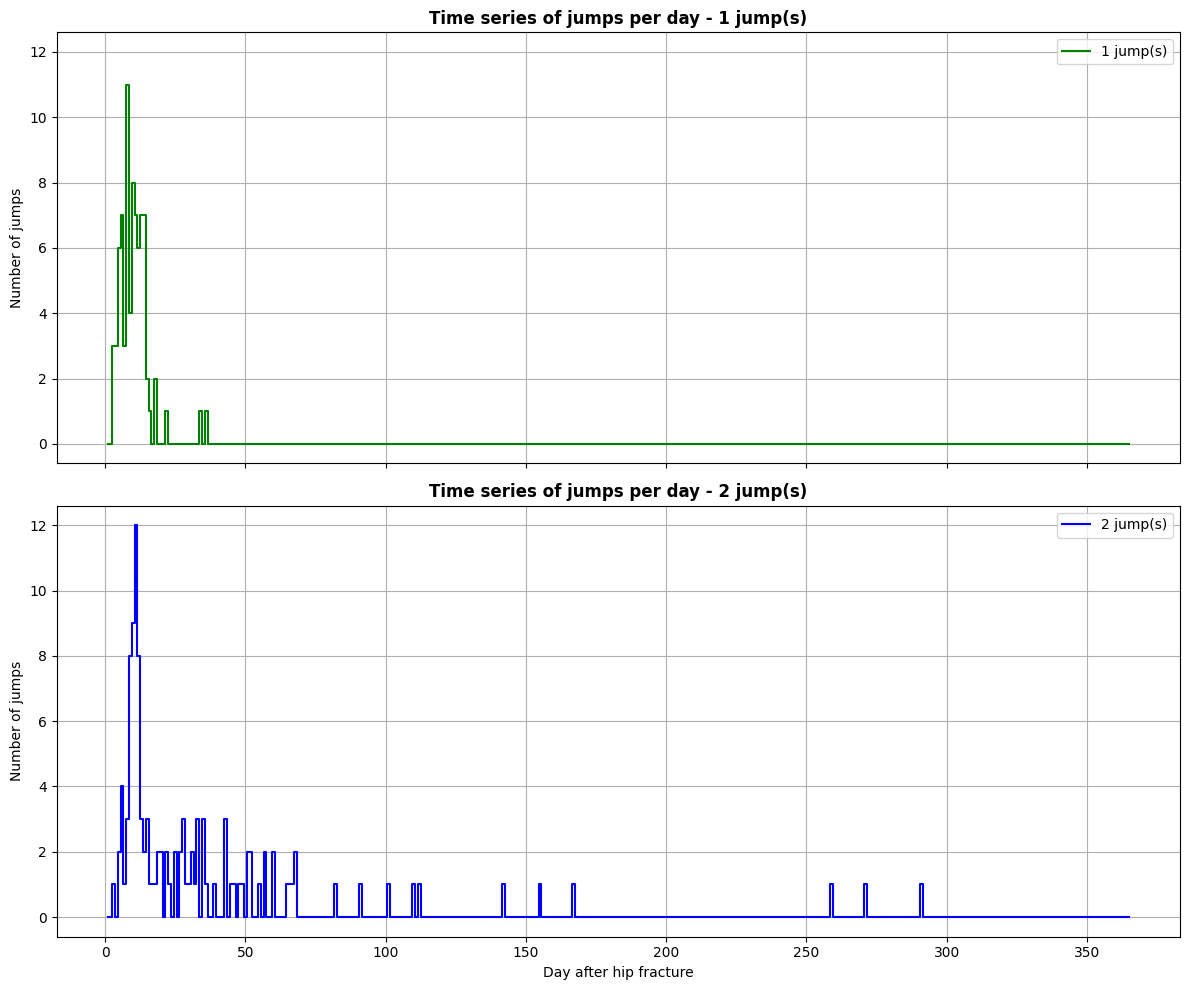

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

colors = {1: "green", 2: "blue"}

for ax, i in zip(axes, [1,2]):
    all_jump_days = [day for sublist in jump_info_OGB[jump_info_OGB["num_jumps"]==i]["jump_days"] for day in sublist]
    day_counts = Counter(all_jump_days)

    days = np.arange(1, 366)
    jump_per_day = [day_counts.get(d, 0) for d in days]

    ax.plot(days, jump_per_day, drawstyle='steps-mid', color=colors[i], label=f"{i} jump(s)")
    ax.set_ylabel("Number of jumps")
    ax.set_title(f"Time series of jumps per day - {i} jump(s)", fontweight='bold')
    ax.grid(True)
    ax.legend()

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 50)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()

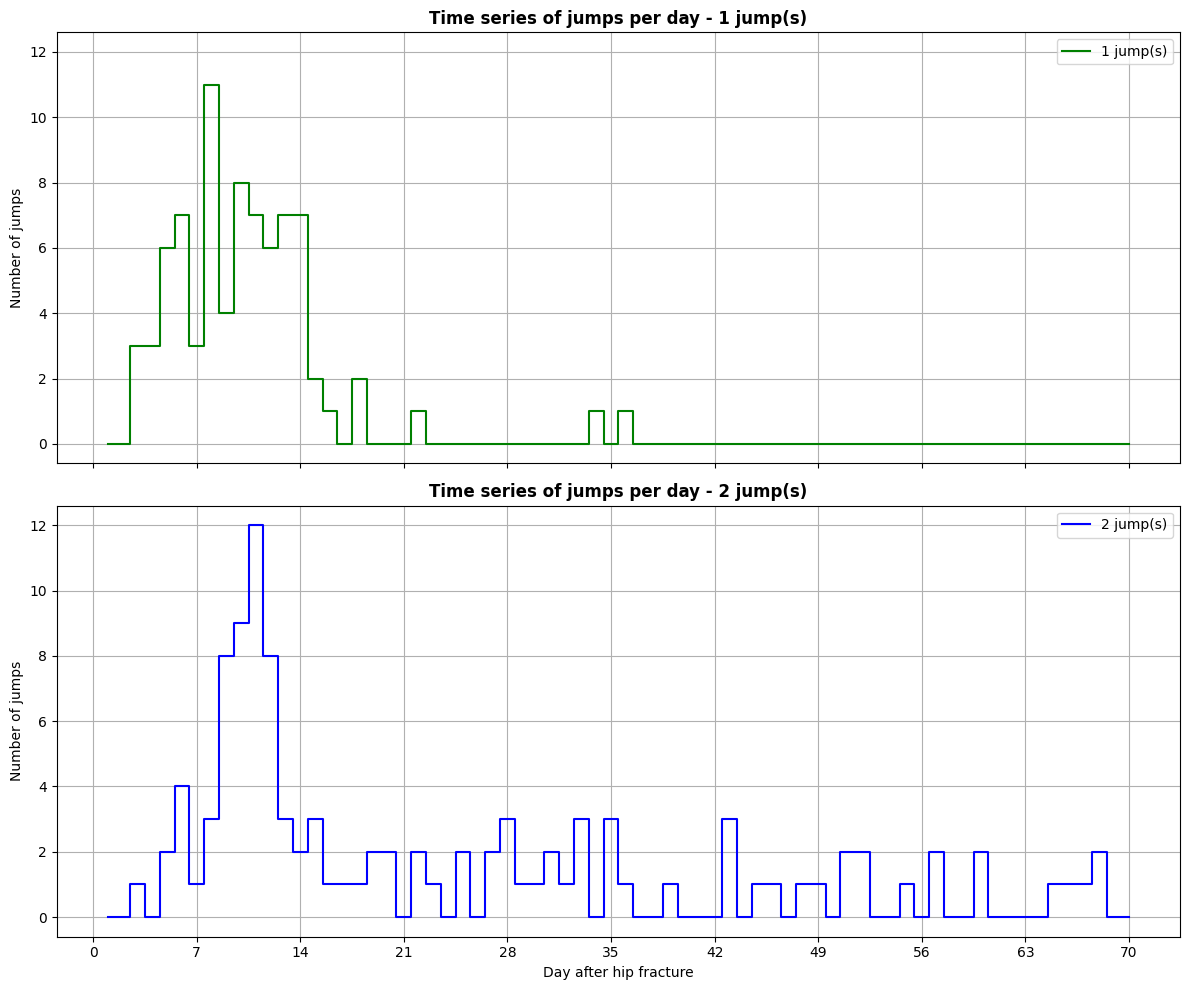

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

colors = {1: "green", 2: "blue"}

for ax, i in zip(axes, [1,2]):
    all_jump_days = [day for sublist in jump_info_OGB[jump_info_OGB["num_jumps"]==i]["jump_days"] for day in sublist]
    day_counts = Counter(all_jump_days)

    days = np.arange(1, 71)
    jump_per_day = [day_counts.get(d, 0) for d in days]

    ax.plot(days, jump_per_day, drawstyle='steps-mid', color=colors[i], label=f"{i} jump(s)")
    ax.set_ylabel("Number of jumps")
    ax.set_title(f"Time series of jumps per day - {i} jump(s)", fontweight='bold')
    ax.grid(True)
    ax.legend()

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 7)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()

***My takeaway:** in hospitalized patients whose situation changed once, this change mostly occurred during 3 weeks.

Analyse patients who get better by "2 jumps" deeper:

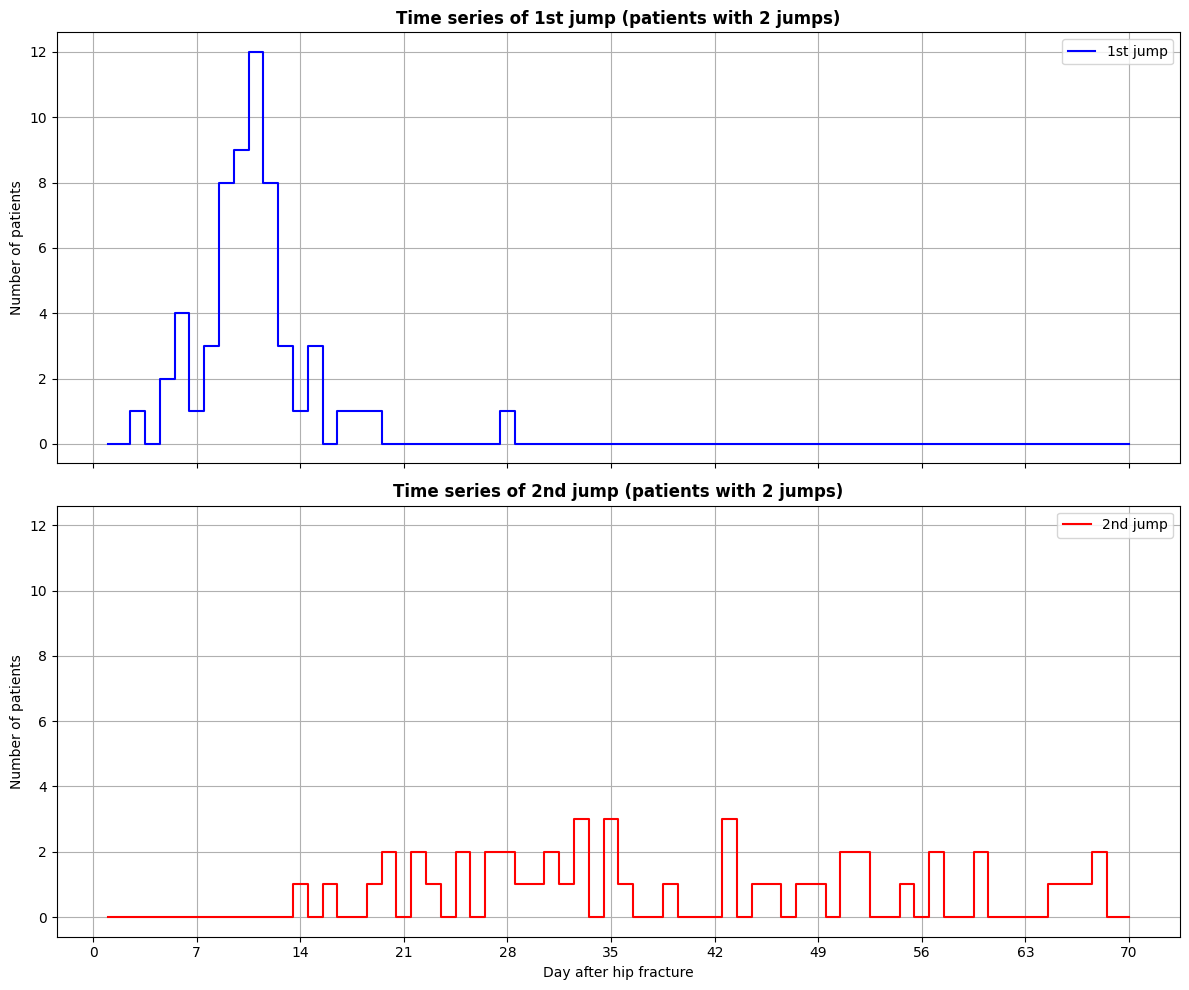

In [ ]:
from collections import Counter


two_jump_patients = jump_info_OGB[jump_info_OGB["num_jumps"] == 2]


first_jumps = [days[0] for days in two_jump_patients["jump_days"]]
second_jumps = [days[1] for days in two_jump_patients["jump_days"]]


first_counts = Counter(first_jumps)
second_counts = Counter(second_jumps)


days = np.arange(1, 71)
first_jump_per_day = [first_counts.get(d, 0) for d in days]
second_jump_per_day = [second_counts.get(d, 0) for d in days]

fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=True)

#first jump chart
axes[0].plot(days, first_jump_per_day, drawstyle='steps-mid', color="blue", label="1st jump")
axes[0].set_ylabel("Number of patients")
axes[0].set_title("Time series of 1st jump (patients with 2 jumps)", fontweight='bold')
axes[0].grid(True)
axes[0].legend()

#second junmp chart
axes[1].plot(days, second_jump_per_day, drawstyle='steps-mid', color="red", label="2nd jump")
axes[1].set_ylabel("Number of patients")
axes[1].set_title("Time series of 2nd jump (patients with 2 jumps)", fontweight='bold')
axes[1].grid(True)
axes[1].legend()

#be in same scale
max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 7)
plt.xticks(xticks)
axes[-1].set_xlabel("Day after hip fracture")

plt.tight_layout()
plt.show()


***My takeaway:** first dwelling changes happened during the first 3 weeks, and mostly they get better within 70days*

#### **Main Result:** for patients in the Improving Situation, the first 3weeks are really important, during this time they leave the hospital (and would get better during 2 months).

Where they end up after each jump(s)

In [ ]:
S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_gb = OGB[S_cols].apply(get_jumps, axis=1)

jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)


labels_map = {0: "home",
              1: "nursing home",
              2: "primary care facility",
              3: "hospital",
              4: "Pass away"}

jump_info_gb["final_stage"] = OGB["S365"].astype(int).map(labels_map)

print(jump_info_gb.groupby("num_jumps")["final_stage"].value_counts())

num_jumps  final_stage          
1          home                     80
           primary care facility    27
           nursing home              7
2          home                     59
           nursing home             24
3          home                      2
Name: count, dtype: int64


In [ ]:
print(jump_info_gb["num_jumps"].value_counts())

num_jumps
1    114
2     83
3      2
Name: count, dtype: int64


persntage analyse:

In [ ]:
print(jump_info_gb.groupby("num_jumps")["final_stage"].value_counts()/jump_info_gb["num_jumps"].value_counts()*100)

num_jumps  final_stage          
1          home                      70.175439
           primary care facility     23.684211
           nursing home               6.140351
2          home                      71.084337
           nursing home              28.915663
3          home                     100.000000
Name: count, dtype: float64


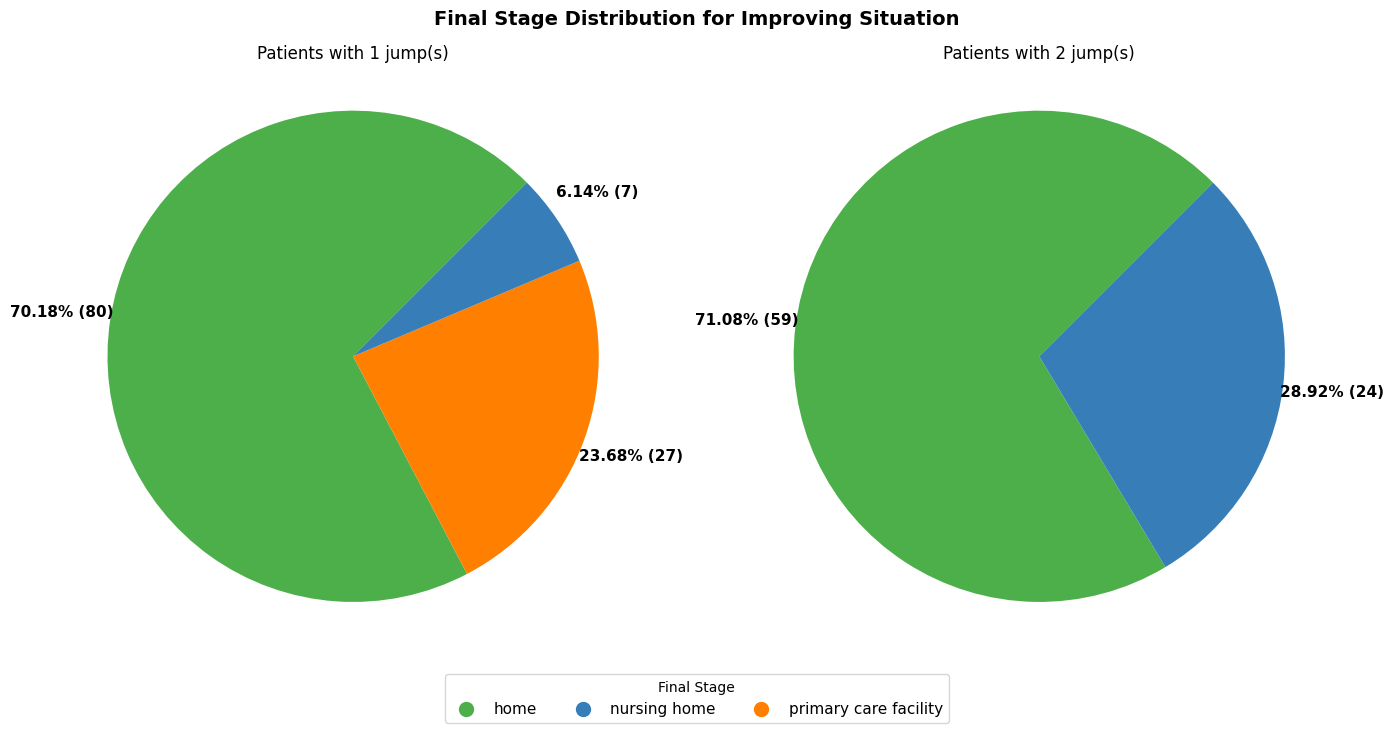

In [ ]:
colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00"
}

grouped = jump_info_gb.groupby("num_jumps")["final_stage"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14,7))

for ax, nj in zip(axes, (1,2)):
    data = grouped[nj]
    labels = data.index
    sizes = data.values
    colors = [colors_map[l] for l in labels]

    wedges, texts = ax.pie(
        sizes,
        labels=None,
        startangle=45,
        colors=colors,
        pctdistance=1.15
    )

    for wedge, size in zip(wedges, sizes):
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        x = 1.2 * np.cos(np.deg2rad(ang))
        y = 1.2 * np.sin(np.deg2rad(ang))
        ax.text(
            x, y,
            f"{size/sum(sizes)*100:.2f}% ({size})",
            ha="center", va="center",
            fontsize=11, fontweight="bold", color="black"
        )

    ax.set_title(f"Patients with {nj} jump(s)",
                 fontsize=12)
    ax.axis("equal")


fig.legend(
    handles=[plt.Line2D([0],[0], color=col, marker='o', linestyle='', markersize=10) for col in colors_map.values()],
    labels=list(colors_map.keys()),
    title="Final Stage",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=11,
    frameon=True
)
plt.suptitle("Final Stage Distribution for Improving Situation", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

***My takeaway:** It's possible that patients in primary care, by 1 jump, have another jump and go home or to a nursing home.*

***My takeaway:** patients with 3 jumps are just 2, so I consider them as outliers.*

I wanna see it a little deeper for 2 jump patients, what's happened after the first jump, then the second

In [ ]:
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 chon diff shift mide
    num_jumps = len(jump_days)

    # calculate durations between jumps
    if num_jumps > 1:
        durations = np.diff(jump_days)
    else:
        durations = np.array([])

    return pd.Series([num_jumps, jump_days, durations],
                     index=["num_jumps", "jump_days", "durations"])

S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_gb = OGB[S_cols].apply(get_jumps, axis=1)
jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)
jump_info_gb.head()

,ID,cluster,num_jumps,jump_days,durations
1,2,Improving Situation,1,[8],[]
3,4,Improving Situation,2,"[15, 29]",[14]
5,6,Improving Situation,2,"[10, 57]",[47]
6,7,Improving Situation,2,"[11, 25]",[14]
9,10,Improving Situation,1,[16],[]


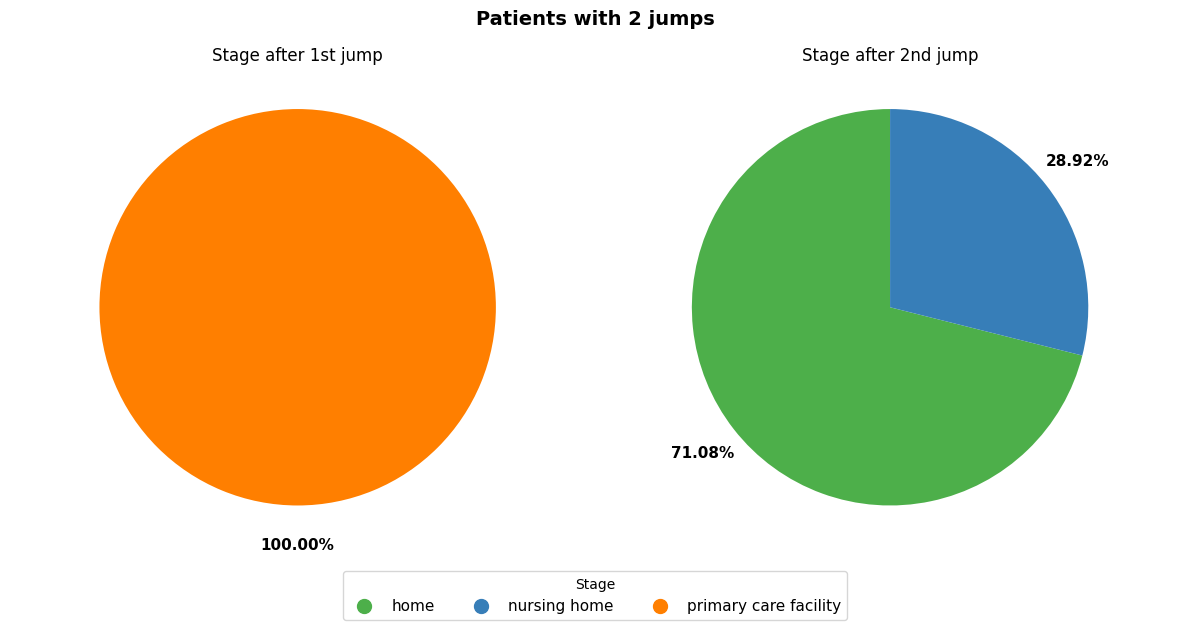

In [ ]:
def get_jumps_with_stages(row):
    values = row[S_cols].values
    diffs = np.diff(values)
    jump_days = np.where(diffs < 0)[0] + 2

    jumps = []
    for d in jump_days:
        from_stage = row[f"S{d-1}"]   # stage before jump
        to_stage   = row[f"S{d}"]     # stage after jump
        jumps.append((from_stage, to_stage))

    return pd.Series([len(jump_days), jump_days, jumps],
                     index=["num_jumps", "jump_days", "jumps"])

jump_info_gb = OGB[S_cols].apply(get_jumps_with_stages, axis=1)
jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)

#2-jump patients selection
two_jump_patients = jump_info_gb[jump_info_gb["num_jumps"] == 2].copy()

#  stages
jump1_stages = [j[0][1] for j in two_jump_patients["jumps"]]
jump2_stages = [j[1][1] for j in two_jump_patients["jumps"]]

jump1_labels = [labels_map[x] for x in jump1_stages]
jump2_labels = [labels_map[x] for x in jump2_stages]

# Count occurrences
jump1_counts = pd.Series(jump1_labels).value_counts()
jump2_counts = pd.Series(jump2_labels).value_counts()

colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00"
}

# --- Plot side-by-side pie charts ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (title, counts) in zip(
    axes,
    [("Stage after 1st jump", jump1_counts),
     ("Stage after 2nd jump", jump2_counts)]
):
    labels = counts.index
    sizes = counts.values
    colors = [colors_map[l] for l in labels]

    wedges, texts = ax.pie(
        sizes,
        labels=None,
        startangle=90,
        colors=colors,
        pctdistance=1.15
    )


    for wedge, size in zip(wedges, sizes):
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        x = 1.2 * np.cos(np.deg2rad(ang))
        y = 1.2 * np.sin(np.deg2rad(ang))
        ax.text(
            x, y,
            f"{size/sum(sizes)*100:.2f}%",
            ha="center", va="center",
            fontsize=11, fontweight="bold", color="black"
        )

    ax.set_title(title, fontsize=12)
    ax.axis("equal")

#legend
fig.legend(
    handles=[plt.Line2D([0],[0], color=col, marker='o', linestyle='', markersize=10) for col in colors_map.values()],
    labels=list(colors_map.keys()),
    title="Stage",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    fontsize=11,
    frameon=True
)

plt.suptitle("Patients with 2 jumps", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

***My takeaway:** 1 jump patients in week 1, they jump to a nursing home or home otherwise, they go to primary care. 2 jumps, in the first week, have their first jump, second jump happens after that in the first month, mostly patients go to home.*

i said: ***My takeaway:** It's possible that patients in primary care, by 1 jump, have another jump and go home or to a nursing home.* **It's wrong if there was a chance their stage would changed during a 11 months after the first change.**

In [ ]:
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    # locate jumps (index+2 since diff shifts)
    jump_days = np.where(diffs < 0)[0] + 2
    num_jumps = len(jump_days)

    # durations
    durations = []
    if num_jumps >= 1:
        # duration from 0 → first jump
        durations.append(jump_days[0])
    if num_jumps >= 2:
        # duration between jump1 → jump2
        durations.append(jump_days[1] - jump_days[0])

    return pd.Series(
        [num_jumps, jump_days, durations],
        index=["num_jumps", "jump_days", "durations"]
    )


# --- Apply to dataset ---
S_cols = [c for c in OGB.columns if str(c).startswith("S")]
jump_info_gb = OGB[S_cols].apply(get_jumps, axis=1)
jump_info_gb = pd.concat([OGB[["ID","cluster"]], jump_info_gb], axis=1)

jump_info_gb.head()

,ID,cluster,num_jumps,jump_days,durations
1,2,Improving Situation,1,[8],[8]
3,4,Improving Situation,2,"[15, 29]","[15, 14]"
5,6,Improving Situation,2,"[10, 57]","[10, 47]"
6,7,Improving Situation,2,"[11, 25]","[11, 14]"
9,10,Improving Situation,1,[16],[16]


/tmp/ipython-input-3952086227.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OGB["jumps"] = OGB[S_cols].apply(get_jumps_with_stages, axis=1)


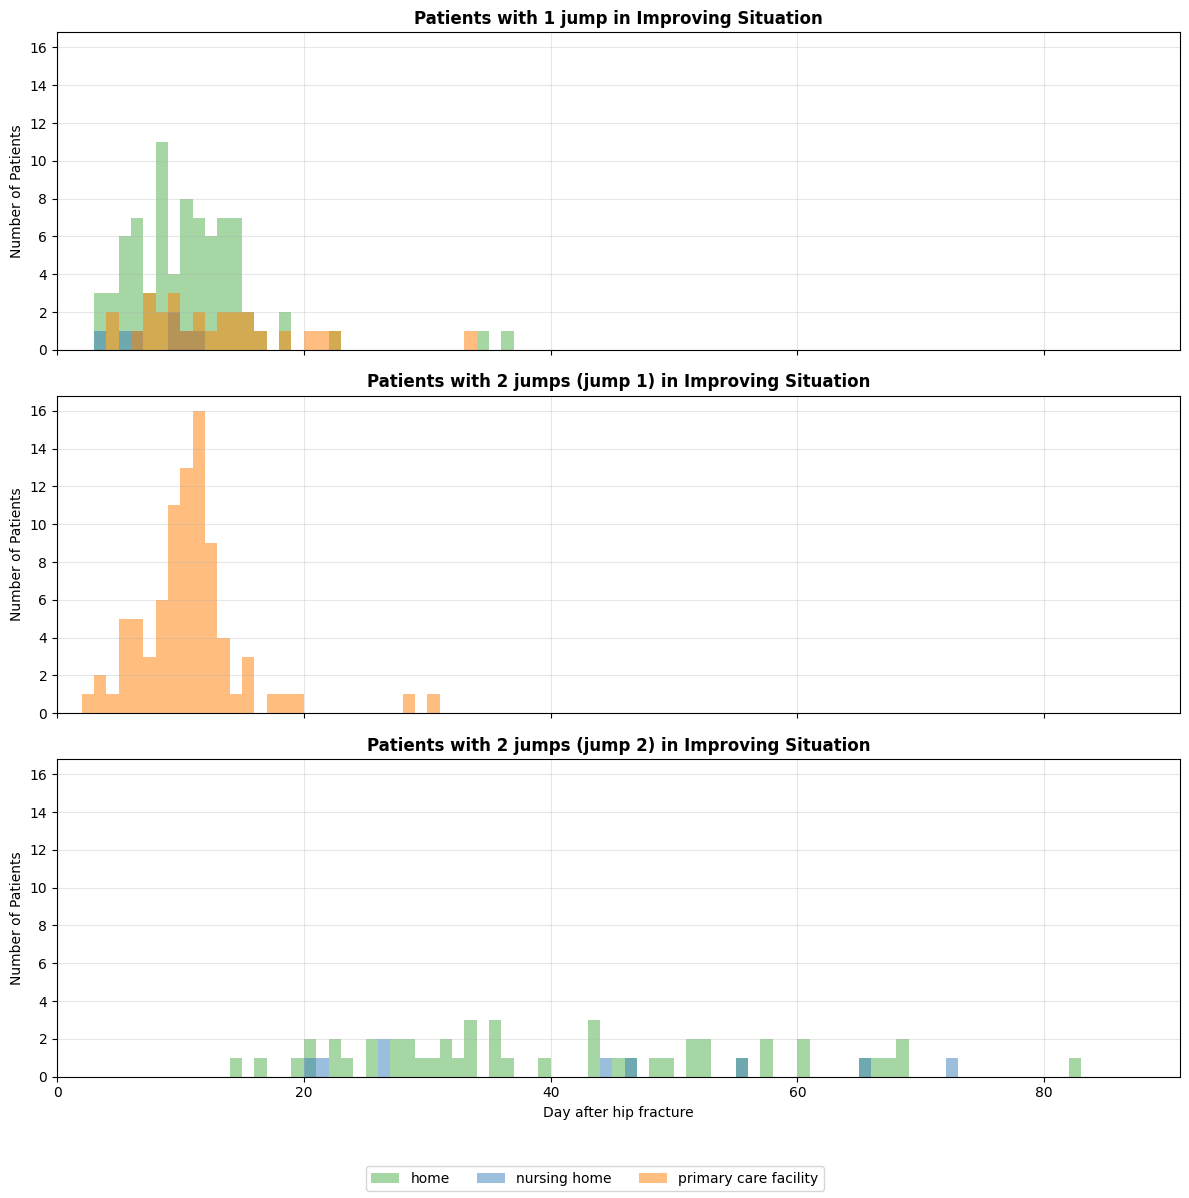

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Stage labels + colors ---
labels_map = {
    0: "home",
    1: "nursing home",
    2: "primary care facility",
    3: "hospital",
    4: "Pass away"
}

colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00",
    "hospital": "#984ea3",
    "Pass away": "#e41a1c"
}

# --- Extract jumps directly from S1...S365 ---
def get_jumps_with_stages(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2   # +2 because np.diff shifts
    jumps = []
    for d in jump_days:
        from_stage = row[f"S{d-1}"]
        to_stage   = row[f"S{d}"]
        jumps.append((d, from_stage, to_stage))
    return jumps

# Apply
S_cols = [c for c in OGB.columns if str(c).startswith("S")]
OGB["jumps"] = OGB[S_cols].apply(get_jumps_with_stages, axis=1)

# --- Collect all jumps by jump number ---
jump1_records, jump2_records, onejump_records = [], [], []

for _, row in OGB.iterrows():
    if len(row["jumps"]) == 1:
        d, f, t = row["jumps"][0]
        onejump_records.append((d, labels_map[t]))
    elif len(row["jumps"]) >= 2:
        d1, f1, t1 = row["jumps"][0]
        d2, f2, t2 = row["jumps"][1]
        jump1_records.append((d1, labels_map[t1]))
        jump2_records.append((d2, labels_map[t2]))

onejump_df = pd.DataFrame(onejump_records, columns=["day", "stage"])
jump1_df   = pd.DataFrame(jump1_records, columns=["day", "stage"])
jump2_df   = pd.DataFrame(jump2_records, columns=["day", "stage"])

# --- Plot function ---
def plot_stage_hist(ax, df, title):
    for stage, subdf in df.groupby("stage"):
        ax.hist(subdf["day"],
                bins=np.arange(0, 366, 1),
                alpha=0.5,
                label=stage,
                color=colors_map[stage])
    ax.set_title(title, fontweight="bold")
    ax.set_ylabel("Number of Patients")
    ax.grid(alpha=0.3)

# --- Draw plots ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

plot_stage_hist(axes[0], onejump_df, "Patients with 1 jump in Improving Situation")
plot_stage_hist(axes[1], jump1_df, "Patients with 2 jumps (jump 1) in Improving Situation")
plot_stage_hist(axes[2], jump2_df, "Patients with 2 jumps (jump 2) in Improving Situation")

axes[2].set_xlabel("Day after hip fracture")
axes[2].set_xlim(0, 91)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Analyze duration between jumps:

In [ ]:
 # Build duration lists
onejump_durations = [row["jumps"][0][0] for _, row in OGB.iterrows() if len(row["jumps"]) == 1]
jump1_durations   = [row["jumps"][0][0] for _, row in OGB.iterrows() if len(row["jumps"]) >= 2]
jump2_durations   = [row["jumps"][1][0] - row["jumps"][0][0] for _, row in OGB.iterrows() if len(row["jumps"]) >= 2]

#long format
dur_data = pd.DataFrame({
    "group": (["Patients with 1 jump"] * len(onejump_durations) +
              ["Patients with 2 jumps (jump 1)"] * len(jump1_durations) +
              ["Patients with 2 jumps (jump 2)"] * len(jump2_durations)),
    "duration": onejump_durations + jump1_durations + jump2_durations
})

analyzing deeper by boxplot

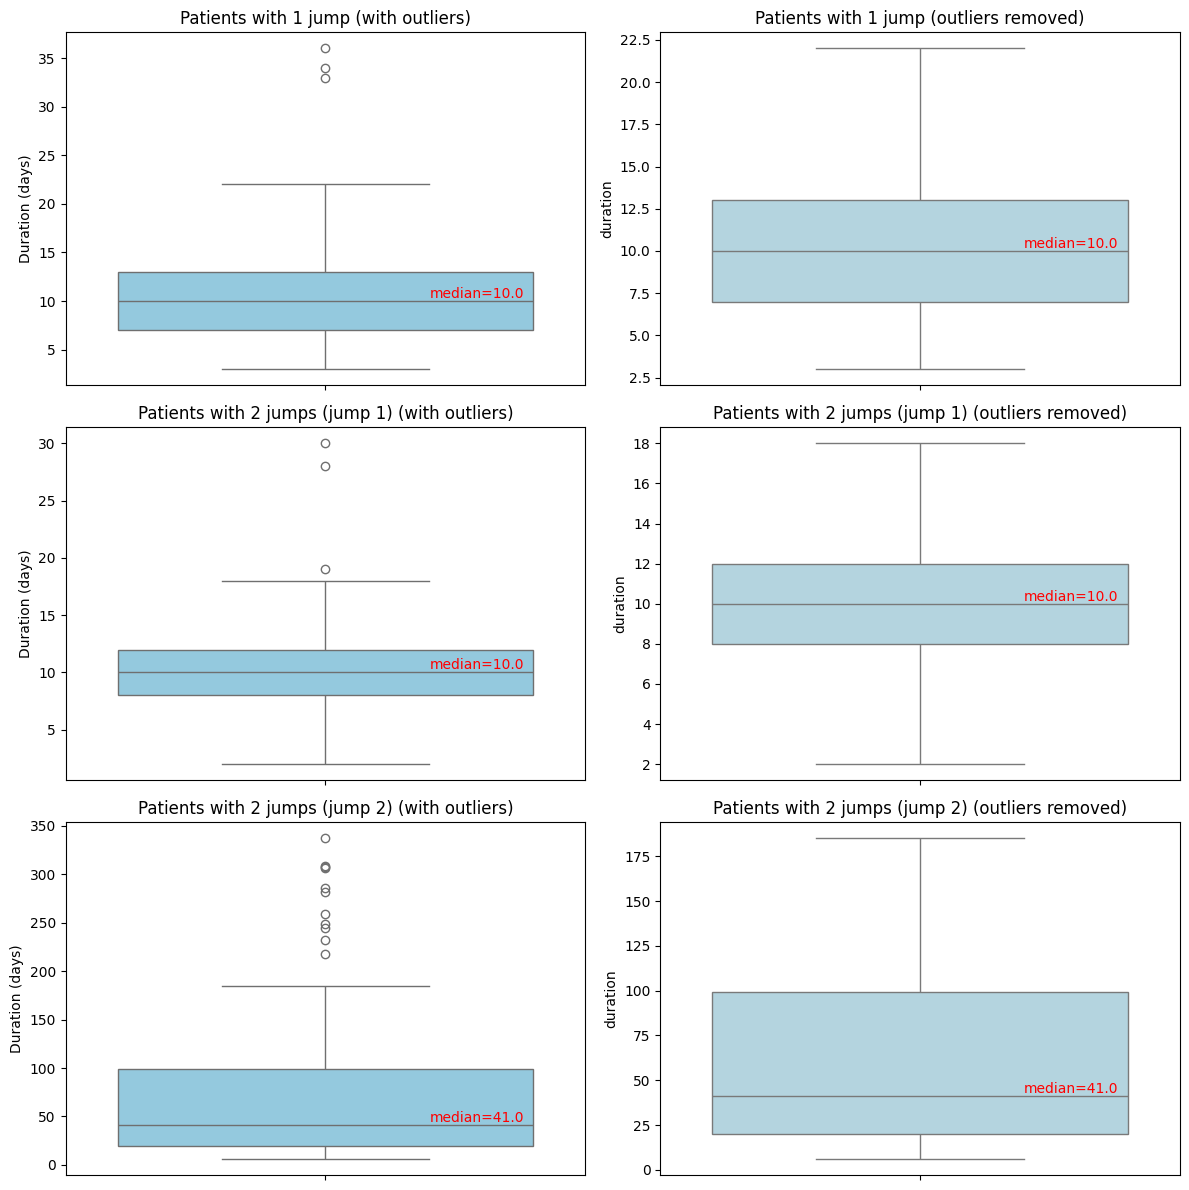

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


groups = dur_data["group"].unique()

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex="col")

for i, g in enumerate(groups):
    data_g = dur_data[dur_data["group"] == g]["duration"]
    median_val = data_g.median()


    sns.boxplot(y=data_g, ax=axes[i,0], color="skyblue")
    axes[i,0].set_title(f"{g} (with outliers)")
    axes[i,0].set_ylabel("Duration (days)")
    #mean_val = data_g.mean()
    axes[i,0].text(0.2, median_val, f"median={median_val:.1f}", color="red", va="bottom")
    #axes[i,0].axhline(mean_val, color="red", linestyle="--", lw=1)
    #axes[i,0].text(0.1, mean_val, f"mean={mean_val:.1f}", color="red", va="bottom")


    sns.boxplot(y=data_g, ax=axes[i,1], color="lightblue", showfliers=False)
    axes[i,1].set_title(f"{g} (outliers removed)")
    #mean_val = data_g.mean()
    axes[i,1].text(0.2, median_val, f"median={median_val:.1f}", color="red", va="bottom")
    #axes[i,1].axhline(mean_val, color="red", linestyle="--", lw=1)
    #axes[i,1].text(0.1, mean_val, f"mean={mean_val:.1f}", color="red", va="bottom")

plt.tight_layout()
plt.show()

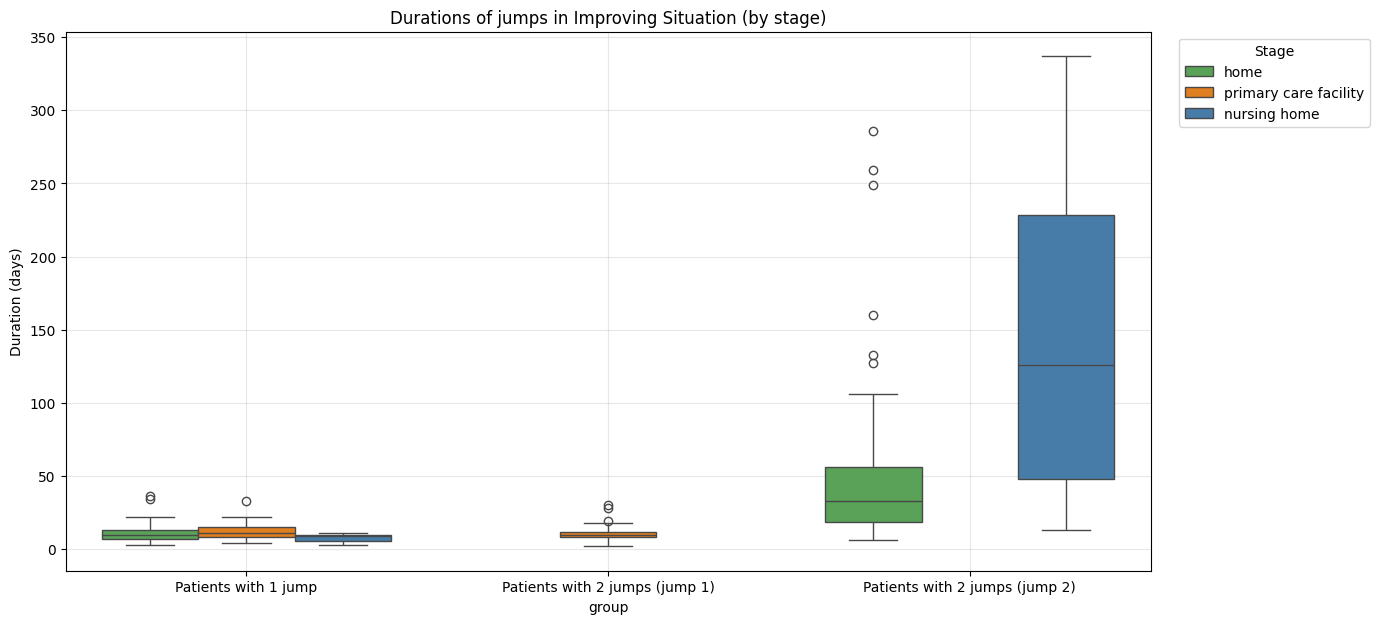

In [ ]:

records = []

for _, row in OGB.iterrows():
    if len(row["jumps"]) == 1:
        d, f, t = row["jumps"][0]
        records.append(("Patients with 1 jump", d, labels_map[t]))
    elif len(row["jumps"]) >= 2:
        d1, f1, t1 = row["jumps"][0]
        d2, f2, t2 = row["jumps"][1]
        records.append(("Patients with 2 jumps (jump 1)", d1, labels_map[t1]))
        records.append(("Patients with 2 jumps (jump 2)", d2 - d1, labels_map[t2]))

dur_stage_df = pd.DataFrame(records, columns=["group","duration","stage"])

plt.figure(figsize=(14,7))
sns.boxplot(
    data=dur_stage_df,
    x="group", y="duration", hue="stage",
    palette=colors_map
)
plt.ylabel("Duration (days)")
plt.title("Durations of jumps in Improving Situation (by stage)")
plt.legend(title="Stage", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-1762192765.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1762192765.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1762192765.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


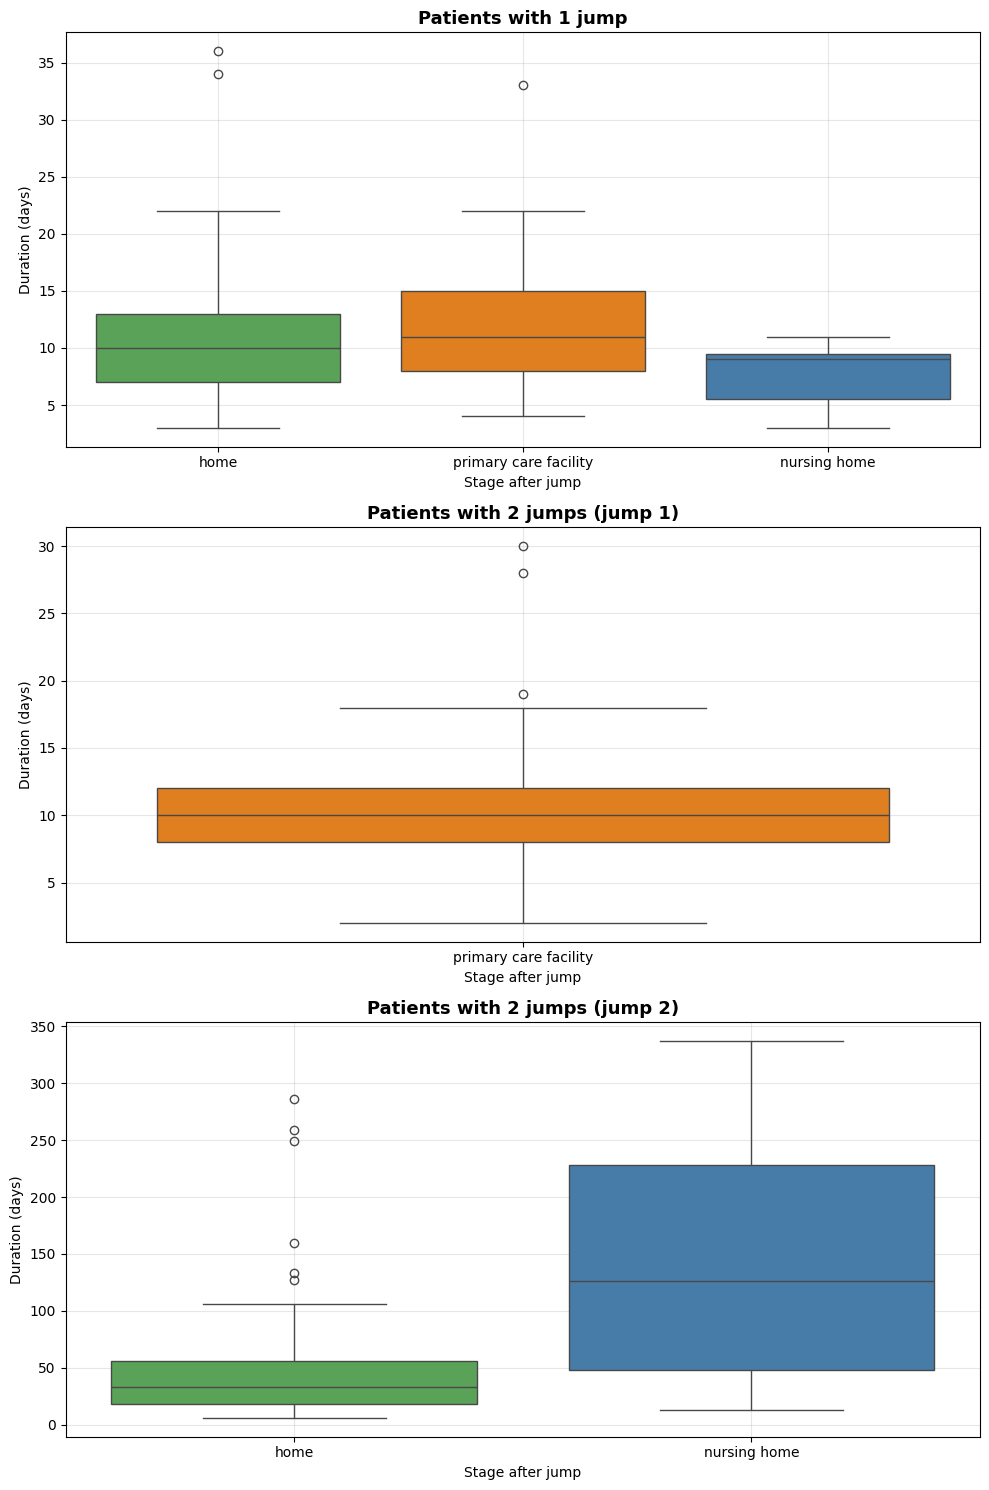

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

groups = dur_stage_df["group"].unique()

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharey=False)

for i, g in enumerate(groups):
    sub = dur_stage_df[dur_stage_df["group"] == g]

    sns.boxplot(
        data=sub,
        x="stage", y="duration",
        palette=colors_map,
        ax=axes[i]
    )

    axes[i].set_title(g, fontsize=13, fontweight="bold")
    axes[i].set_xlabel("Stage after jump")
    axes[i].set_ylabel("Duration (days)")
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Getting virtual output by ChatGPT

In [ ]:
import plotly.graph_objects as go

# Example data
labels = ["Hospital", "Home", "Nursing", "Primary care"]
# Step 1: Hospital to somewhere
sources = [0, 0, 0]   # Hospital
targets = [1, 2, 3]   # Home, Nursing, Primary care
values  = [80, 7, 27]

# Step 2: From Primary care to somewhere
sources += [3, 3]
targets += [1, 2]
values  += [10, 5]

colors = ['#1f77b4', '#2563eb', '#1d4ed8', '#16a34a', '#15803d']

# Alluvial diagram with two steps (like Sankey but layered)
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=labels,
        color="lightgray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors
    )
))

fig.update_layout(title_text="Alluvial Diagram of Patient Transitions", font_size=16)
fig.show()


# Analyzing patients with unstable situation:

In [ ]:
unstable_situation = df[df["cluster"]=="Fluctuating Situation"]
unstable_situation.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
8,9,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
10,11,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,Fluctuating Situation


Patients stage in Day 1:

In [ ]:
print("Total patients in Fluctuating Situation: ", unstable_situation.shape[0])
print("home: ", unstable_situation[unstable_situation["S1"]==0].shape[0])
print("nursing home: ", unstable_situation[unstable_situation["S1"]==1].shape[0])
print("primary care facility: ", unstable_situation[unstable_situation["S1"]==2].shape[0])
print("hospital: ", unstable_situation[unstable_situation["S1"]==3].shape[0])

Total patients in Fluctuating Situation:  278
home:  5
nursing home:  0
primary care facility:  7
hospital:  266


How many patients got hospitalized on day 1 / what percentage % of them are in the unstable situation?

In [ ]:
labels_map = {0: "home", 4: "Pass away", 1:"nursing home" , 2:"primary care facility" , 3:"hospital" }

unstable_situation_counts = unstable_situation["S1"].replace(labels_map).value_counts()
all_counts = df["S1"].replace(labels_map).value_counts()

unstable_situation_hospital = unstable_situation_counts.get("primary care facility", 0)
all_hospital = all_counts.get("primary care facility", 0)

percentage = (unstable_situation_hospital / all_hospital * 100)

print(f"Primary care in first day through Fluctuating Situation: {unstable_situation_hospital}")
print(f"Primary care  in first day through all patients: {all_hospital}")
print(f"Percentage: {percentage:.2f}%")

Primary care in first day through Fluctuating Situation: 7
Primary care  in first day through all patients: 8
Percentage: 87.50%


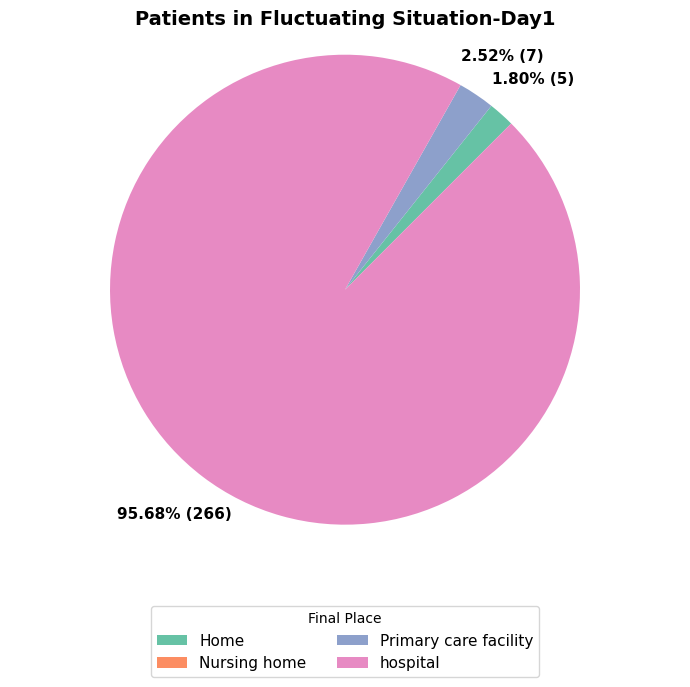

In [ ]:
labels = ["Home", "Nursing home", "Primary care facility", "hospital"]
sizes = [
    unstable_situation[unstable_situation["S1"]==0].shape[0],
    unstable_situation[unstable_situation["S1"]==1].shape[0],
    unstable_situation[unstable_situation["S1"]==2].shape[0],
    unstable_situation[unstable_situation["S1"]==3].shape[0]
]


colors = sns.color_palette("Set2", n_colors=len(labels))


fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)


for wedge, size in zip(wedges, sizes):
  if size > 0:
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.2
    y = np.sin(np.deg2rad(ang)) * 1.2
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.2f}% ({size})",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )


ax.set_title("Patients in Fluctuating Situation-Day1",
             fontsize=14, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Final Place",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

In [ ]:
df[df["S1"]==2]["cluster"].value_counts()

,count
cluster,
Fluctuating Situation,7
Declining Situation,1


***My takeaway:** It's rare to give primary care after surgery, and the patient's stage is fluctuating mostly; it's better to hospitalize them instead.*

if we send them to hospital it would be better?

In [ ]:
df[(df["S1"] == 2) & (df["cluster"] == "Fluctuating Situation")]

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
10,11,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,Fluctuating Situation
62,63,2,2,2,2,2,2,1,1,1,...,4,4,4,4,4,4,4,4,4,Fluctuating Situation
79,80,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
271,272,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,Fluctuating Situation
285,286,2,2,2,2,3,3,2,2,3,...,4,4,4,4,4,4,4,4,4,Fluctuating Situation
417,418,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,Fluctuating Situation
422,423,2,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,Fluctuating Situation


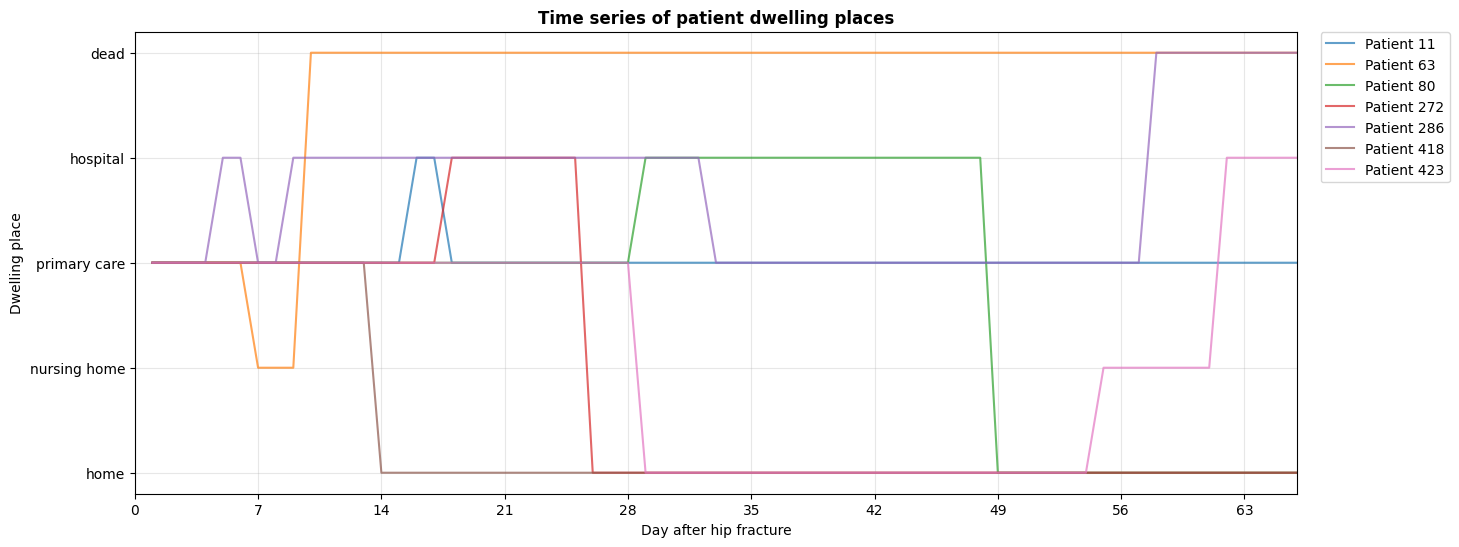

In [ ]:
subset = df[(df["S1"] == 2) & (df["cluster"] == "Fluctuating Situation")]

plt.figure(figsize=(15,6))

for idx, row in subset.iterrows():
    values = row.drop(["ID", "cluster"]).values
    plt.plot(range(1, 366), values, alpha=0.7, label=f"Patient {row['ID']}")

plt.xlabel("Day after hip fracture")
plt.ylabel("Dwelling place")
plt.title("Time series of patient dwelling places", fontweight='bold')

plt.yticks([0,1,2,3,4], ["home","nursing home","primary care","hospital","dead"])
plt.xticks(np.arange(0, 366, 7))
plt.xlim(0, 66)
plt.grid(True, alpha=0.3)
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)
plt.show()

**Main Result:** It is better to keep patients in the hospital after surgery instead of primary care to prevent fluctuations in their condition.

most of the Fluctuation happened during first month.., I think it's better to keep them in hospital for 1 month

Patients stage in Day 365:

In [ ]:
print("Total patients in Fluctuating Situation: ", unstable_situation.shape[0])
print("home: ", unstable_situation[unstable_situation["S365"]==0].shape[0])
print("nursing home: ", unstable_situation[unstable_situation["S365"]==1].shape[0])
print("primary care facility: ", unstable_situation[unstable_situation["S365"]==2].shape[0])
print("hospital: ", unstable_situation[unstable_situation["S365"]==3].shape[0])
print("dead: ", unstable_situation[unstable_situation["S365"]==4].shape[0])

Total patients in Fluctuating Situation:  278
home:  125
nursing home:  26
primary care facility:  26
hospital:  3
dead:  98


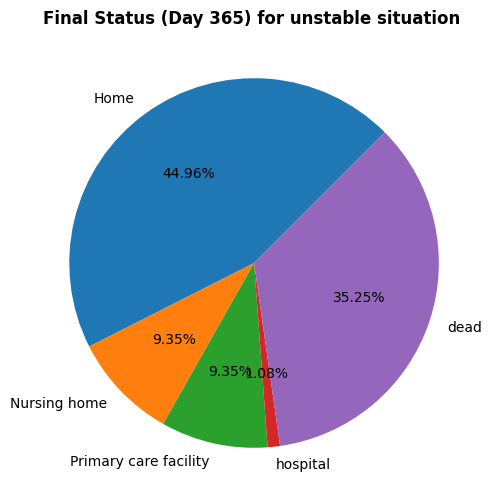

In [ ]:
#pie chart
labels = ["Home", "Nursing home", "Primary care facility", "hospital", 'dead']
sizes = [
    unstable_situation[unstable_situation["S365"]==0].shape[0],
    unstable_situation[unstable_situation["S365"]==1].shape[0],
    unstable_situation[unstable_situation["S365"]==2].shape[0],
    unstable_situation[unstable_situation["S365"]==3].shape[0],
    unstable_situation[unstable_situation["S365"]==4].shape[0]
]


plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Final Status (Day 365) for unstable situation ", fontweight='bold')
plt.show()

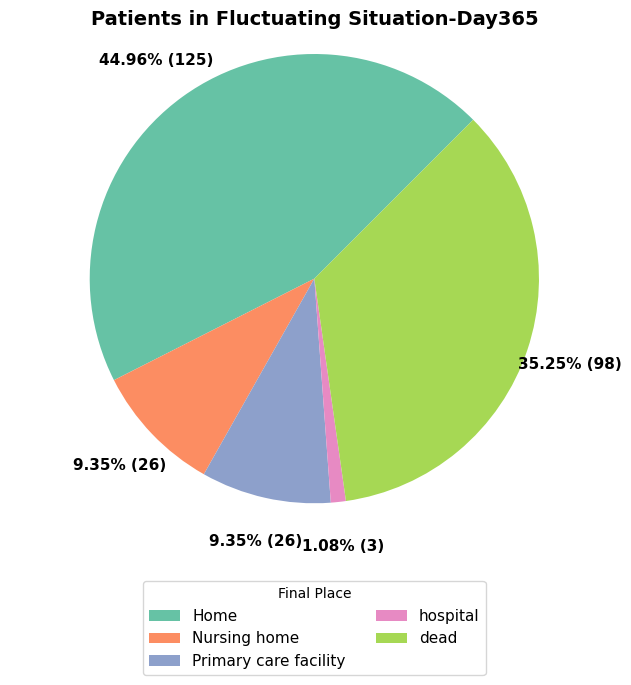

In [ ]:
labels = ["Home", "Nursing home", "Primary care facility", "hospital", "dead"]
sizes = [
    unstable_situation[unstable_situation["S365"]==0].shape[0],
    unstable_situation[unstable_situation["S365"]==1].shape[0],
    unstable_situation[unstable_situation["S365"]==2].shape[0],
    unstable_situation[unstable_situation["S365"]==3].shape[0],
    unstable_situation[unstable_situation["S365"]==4].shape[0]
]


colors = sns.color_palette("Set2", n_colors=len(labels))


fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)


for wedge, size in zip(wedges, sizes):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.2
    y = np.sin(np.deg2rad(ang)) * 1.2
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.2f}% ({size})",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )


ax.set_title("Patients in Fluctuating Situation-Day365",
             fontsize=14, fontweight="bold")


ax.axis("equal")


plt.legend(
    wedges,
    labels,
    title="Final Place",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

***My takeaway:** In a fluctuating situation, in a year, the rate of death and getting back home are really close to each other.*

How many times jump and when

In [ ]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs < 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info_unstable_situation = unstable_situation[unstable_situation["S365"]==0].drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info_unstable_situation.head()

,num_jumps,jump_days
0,3,"[10, 45, 107]"
2,5,"[22, 58, 92, 134, 183]"
4,6,"[8, 49, 124, 139, 226, 236]"
8,4,"[19, 33, 119, 173]"
13,4,"[10, 58, 98, 177]"


In [ ]:

def get_jumps_all_changes(row):
    values = row.values
    diffs = np.diff(values)


    jump_days = np.where(diffs != 0)[0] + 2
    num_jumps = len(jump_days)

    #durations
    durations = []
    if num_jumps >= 1:
        durations.append(jump_days[0])
    if num_jumps > 1:
        for i in range(1, num_jumps):
            durations.append(jump_days[i] - jump_days[i-1])

    return pd.Series(
        [num_jumps, jump_days, durations],
        index=["num_jumps", "jump_days", "durations"]
    )


jump_info_unstable_situation = (
    unstable_situation[unstable_situation["S365"]==0]
    .drop(["ID", "cluster"], axis=1)
    .apply(get_jumps_all_changes, axis=1)
)


print(jump_info_unstable_situation[8:13])

    num_jumps                       jump_days                    durations
37          4              [12, 50, 110, 111]              [12, 38, 60, 1]
43          7  [8, 28, 41, 88, 130, 277, 284]  [8, 20, 13, 47, 42, 147, 7]
44          6     [8, 72, 243, 251, 281, 282]       [8, 64, 171, 8, 30, 1]
47          5         [4, 195, 199, 335, 346]         [4, 191, 4, 136, 11]
49          3                  [17, 138, 148]                [17, 121, 10]


In [ ]:
jump_info_unstable_situation["num_jumps"].value_counts().sort_index()

,count
num_jumps,
2,5
3,23
4,35
5,15
6,11
7,6
8,7
9,4
10,2


/tmp/ipython-input-3329285886.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




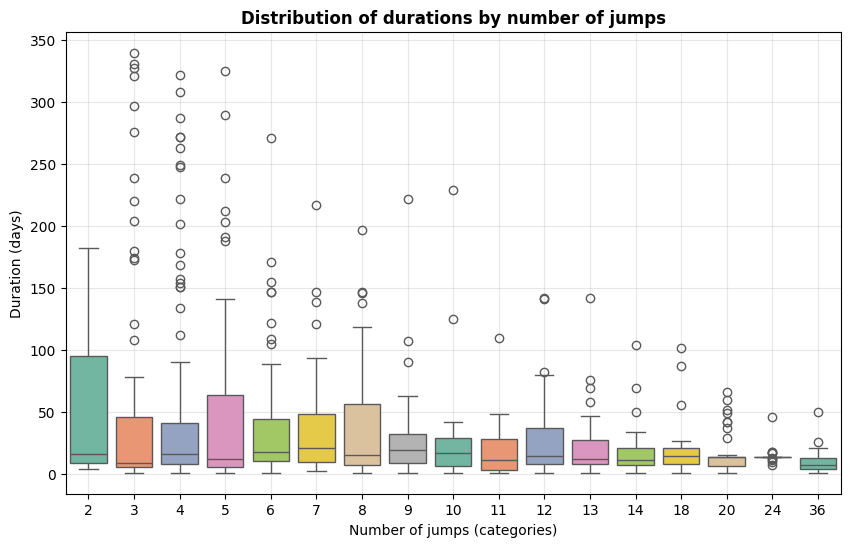

In [ ]:
#long
records = []
for idx, row in jump_info_unstable_situation.iterrows():
    for d in row["durations"]:
        records.append((row["num_jumps"], d))

dur_df = pd.DataFrame(records, columns=["num_jumps", "duration"])

#boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=dur_df,
    x="num_jumps",
    y="duration",
    palette="Set2"
)

plt.xlabel("Number of jumps (categories)")
plt.ylabel("Duration (days)")
plt.title("Distribution of durations by number of jumps", fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipython-input-3162821779.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




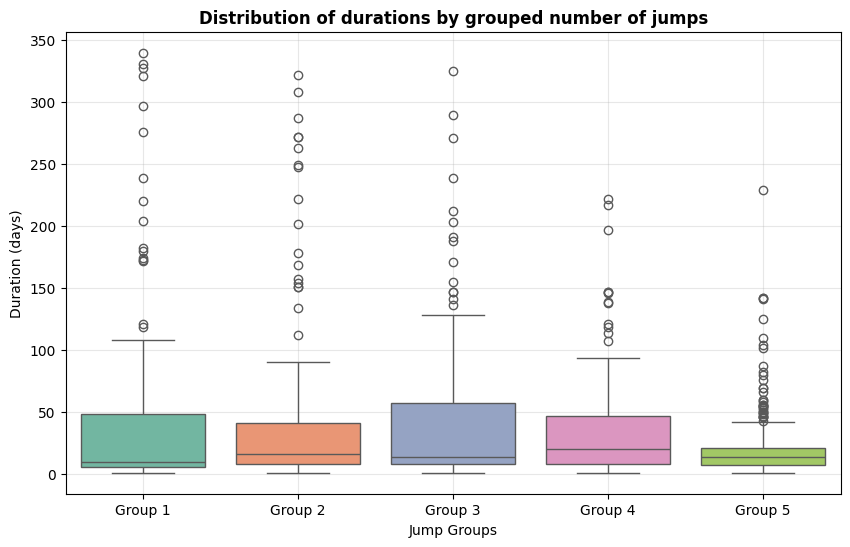

In [ ]:
def categorize_jumps(n):
    if n in [2, 3]:
        return "Group 1"
    elif n == 4:
        return "Group 2"
    elif n in [5, 6]:
        return "Group 3"
    elif n in [7, 8, 9]:
        return "Group 4"
    else:
        return "Group 5"


dur_df["jump_group"] = dur_df["num_jumps"].apply(categorize_jumps)

order = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]


dur_df["jump_group"] = pd.Categorical(dur_df["jump_group"], categories=order, ordered=True)


plt.figure(figsize=(10,6))
sns.boxplot(
    data=dur_df,
    x="jump_group",
    y="duration",
    palette="Set2",
    order=order
)

plt.xlabel("Jump Groups")
plt.ylabel("Duration (days)")
plt.title("Distribution of durations by grouped number of jumps", fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

I analyzed the frequency of patients for each jump count in the unstable cluster. Based on this frequency, I proposed five groups for statistical comparison between groups.

In [ ]:
jump_info_unstable_situation["jump_group"]=jump_info_unstable_situation["num_jumps"].apply(categorize_jumps)

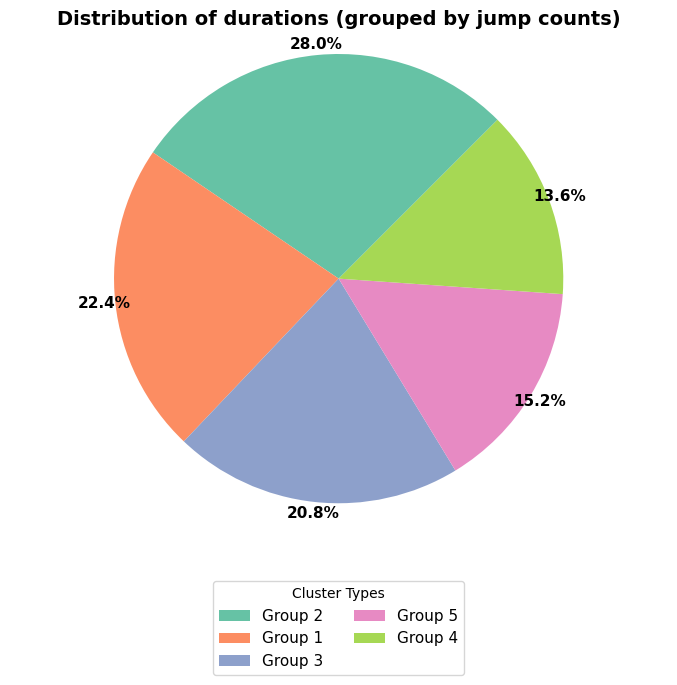

In [ ]:
subset = jump_info_unstable_situation["jump_group"].value_counts()
sizes = subset.values
labels = subset.index

# Colors (one per cluster)
colors = sns.color_palette("Set2", n_colors=len(labels))

# Pie chart
fig, ax = plt.subplots(figsize=(7,7))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=45,
    colors=colors,
    pctdistance=1.15
)

# Add percentage + count outside
for wedge, size in zip(wedges, sizes):
    ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.deg2rad(ang)) * 1.05
    y = np.sin(np.deg2rad(ang)) * 1.05
    ax.text(
        x, y,
        f"{size/sum(sizes)*100:.1f}%",
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )

# Title
ax.set_title("Distribution of durations (grouped by jump counts)",
             fontsize=14, fontweight="bold")

# Equal aspect ratio for circle
ax.axis("equal")

# Legend below
plt.legend(
    wedges,
    labels,
    title="Cluster Types",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

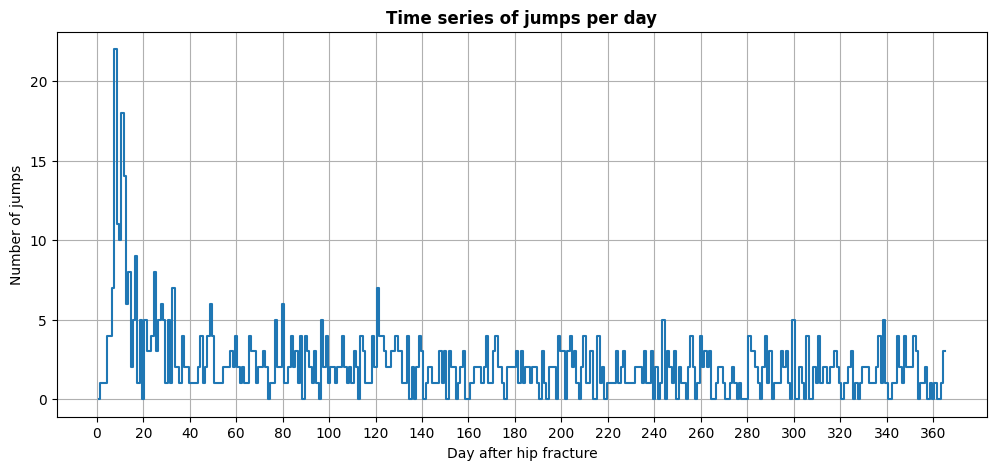

In [ ]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_unstable_situation["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 20)
plt.xticks(xticks)

plt.grid(True)
plt.show()


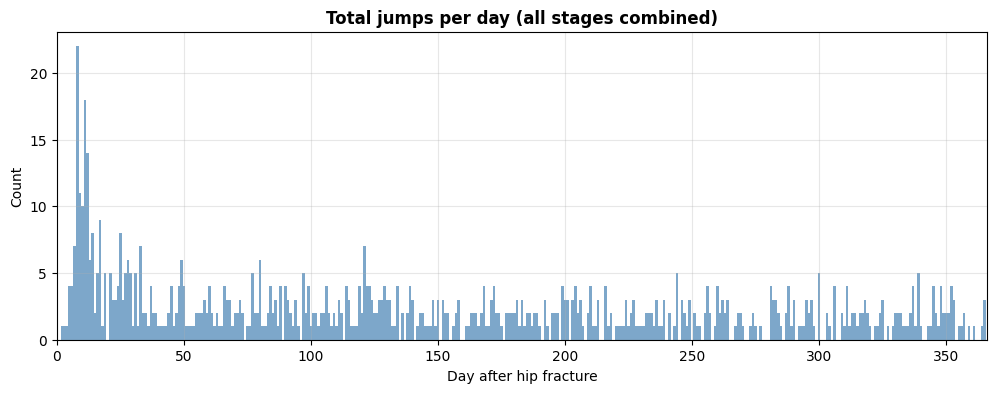

In [ ]:
max_jumps = jump_info_unstable_situation["num_jumps"].max()
days = np.arange(1, 366)


daily_counts = np.zeros_like(days, dtype=int)

for _, row in jump_info_unstable_situation.iterrows():
    for d in row["jump_days"]:
        daily_counts[d-1] += 1

#  Plot bar chart
plt.figure(figsize=(12, 4))
plt.bar(days, daily_counts, color="steelblue", alpha=0.7, width=1.0)

plt.title("Total jumps per day (all stages combined)", fontweight="bold")
plt.xlabel("Day after hip fracture")
plt.ylabel("Count")
plt.xlim(0, 366)
plt.grid(alpha=0.3)

plt.show()

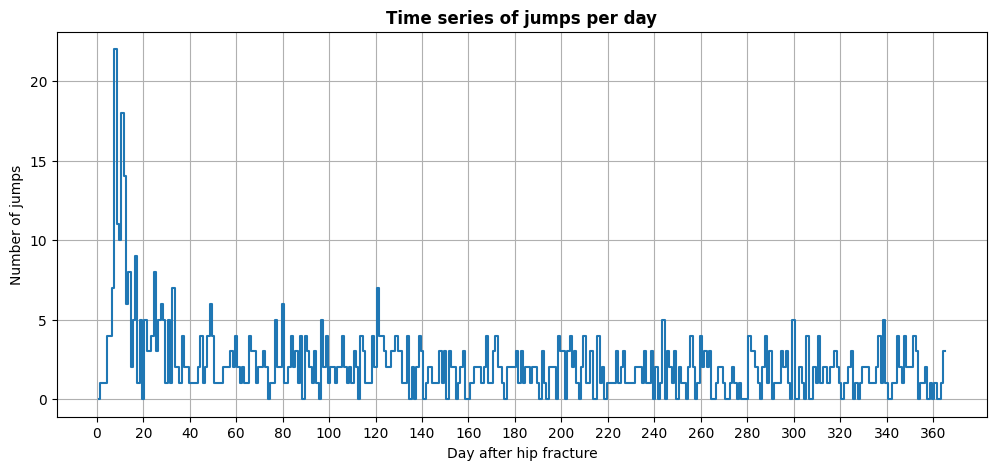

In [ ]:
from collections import Counter

all_jump_days = [day for sublist in jump_info_unstable_situation["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 20)
plt.xticks(xticks)

plt.grid(True)
plt.show()


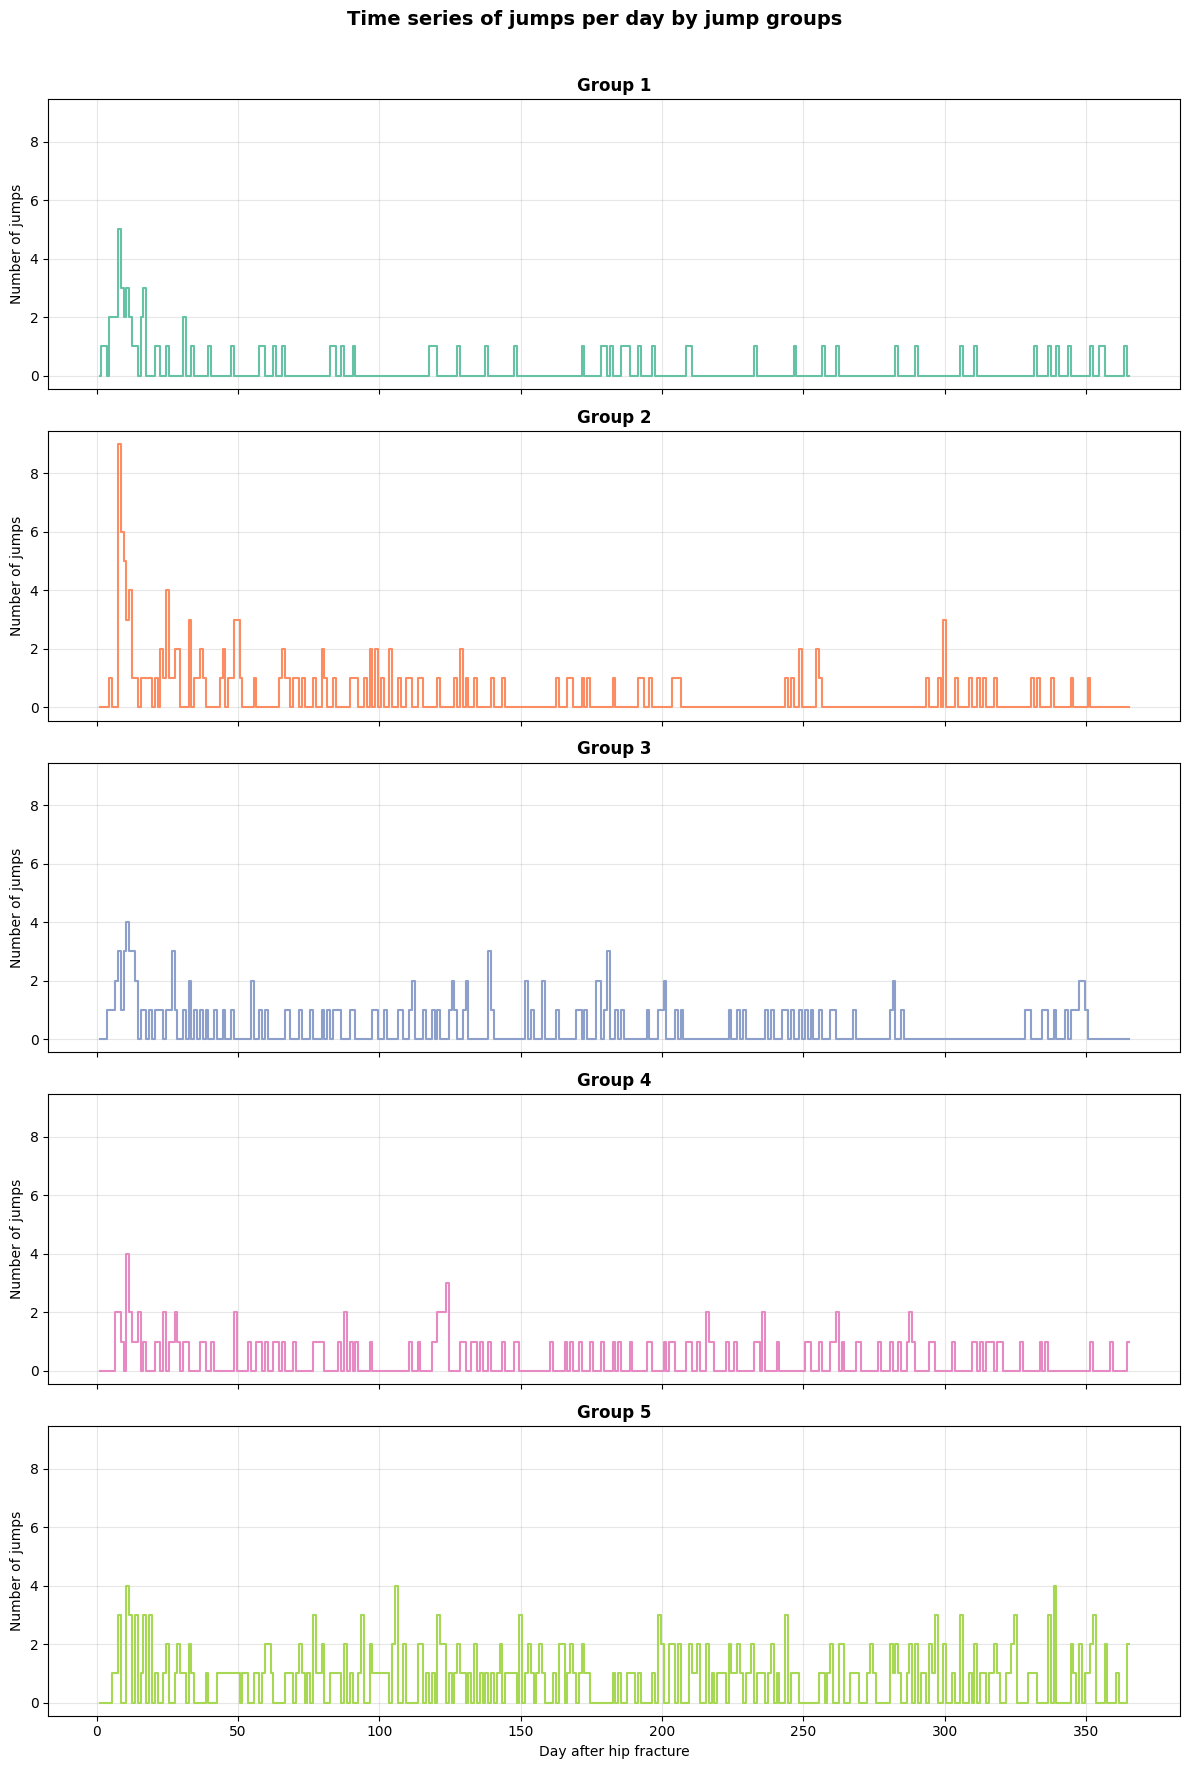

In [ ]:
jump_info_unstable_situation["jump_group"] = jump_info_unstable_situation["num_jumps"].apply(categorize_jumps)

# --- Build per-group jump counts ---
days = np.arange(1, 366)
group_counts = {g: np.zeros_like(days, dtype=int) for g in ["Group 1","Group 2","Group 3","Group 4","Group 5"]}

for _, row in jump_info_unstable_situation.iterrows():
    g = row["jump_group"]
    for d in row["jump_days"]:
        group_counts[g][d-1] += 1  # d-1 because index starts from 0

# --- Plot ---
colors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854"]
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True, sharey=True)

for ax, (g, col) in zip(axes, zip(group_counts.keys(), colors)):
    ax.plot(days, group_counts[g], color=col, drawstyle="steps-mid")
    ax.set_title(f"{g}", fontweight="bold")
    ax.set_ylabel("Number of jumps")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Day after hip fracture")

# add a common title
fig.suptitle("Time series of jumps per day by jump groups", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

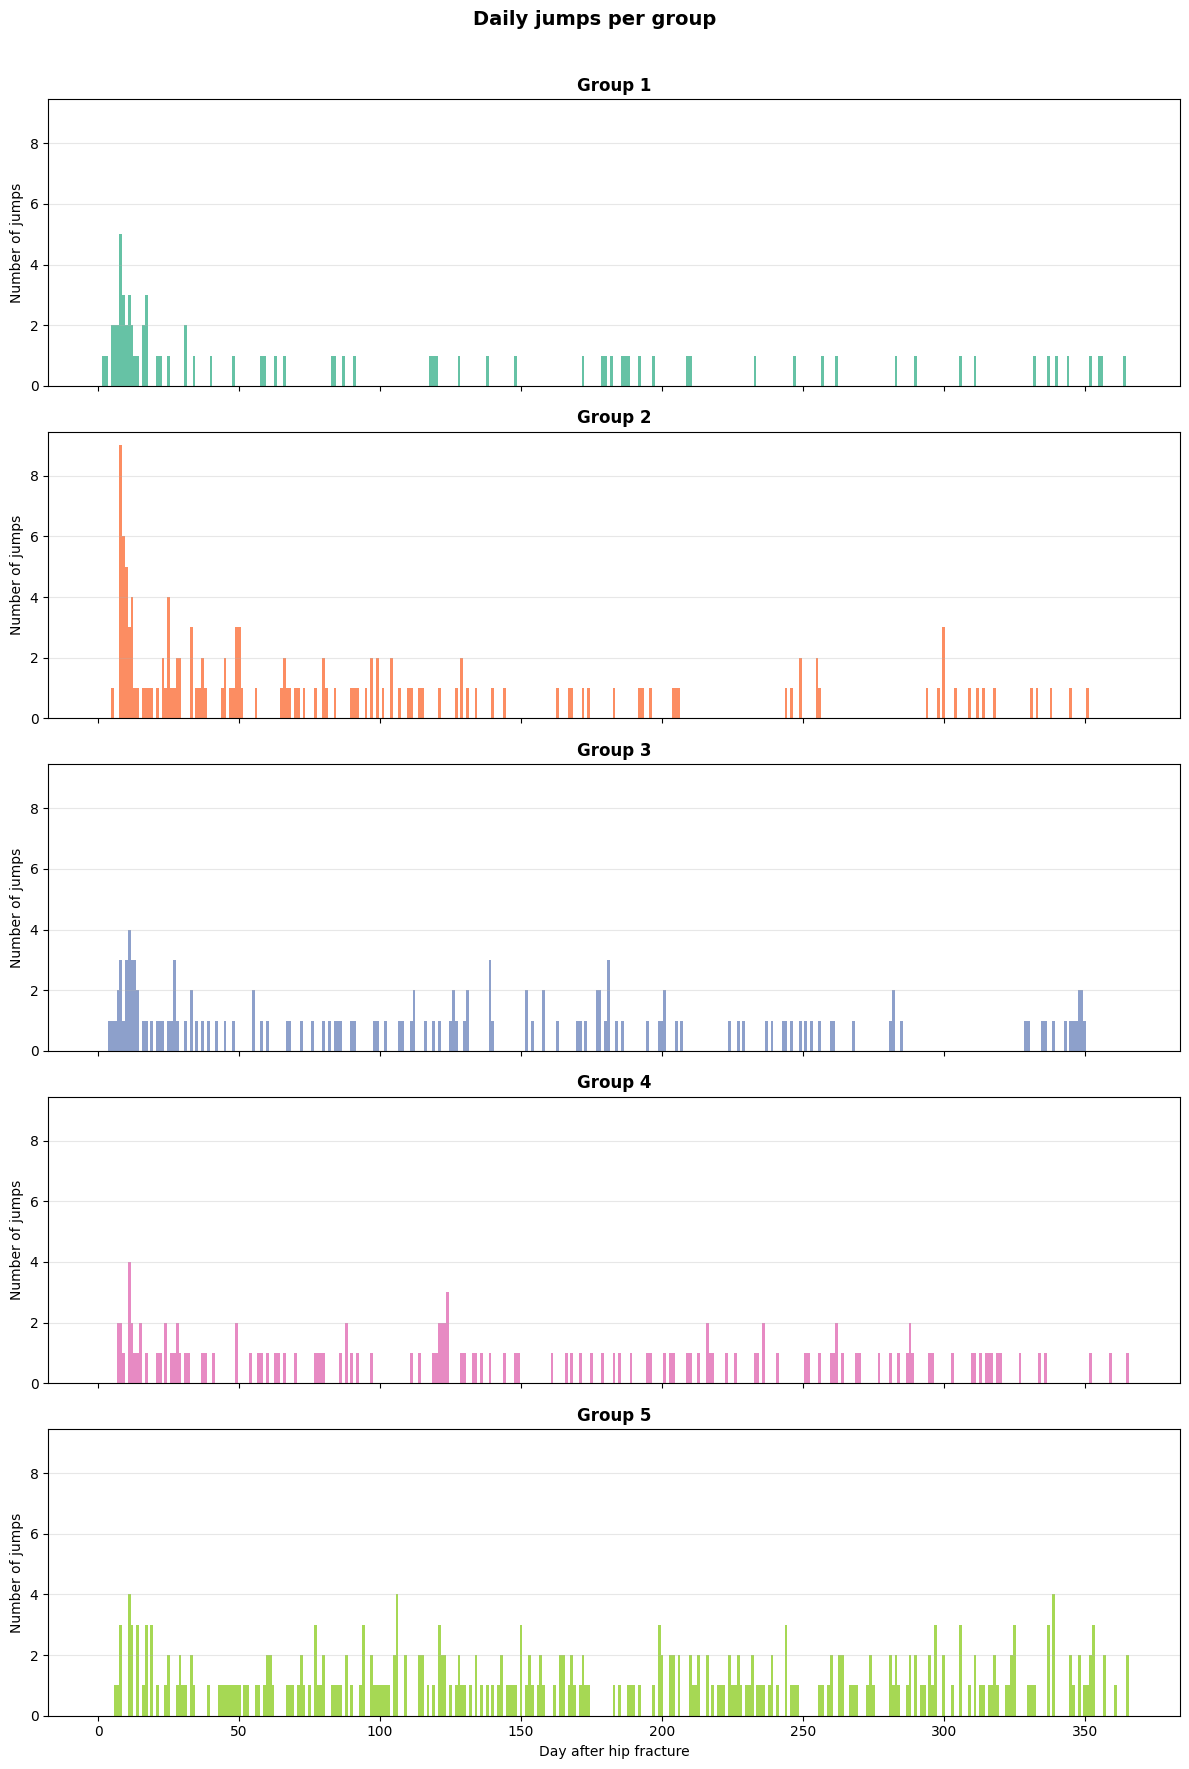

In [ ]:
# --- Plot as bar chart ---
colors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854"]
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True, sharey=True)

for ax, (g, col) in zip(axes, zip(group_counts.keys(), colors)):
    ax.bar(days, group_counts[g], color=col, width=1.0)  # width=1.0 for daily bars
    ax.set_title(f"{g}", fontweight="bold")
    ax.set_ylabel("Number of jumps")
    ax.grid(alpha=0.3, axis="y")

axes[-1].set_xlabel("Day after hip fracture")

# add a common title
fig.suptitle("Daily jumps per group", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

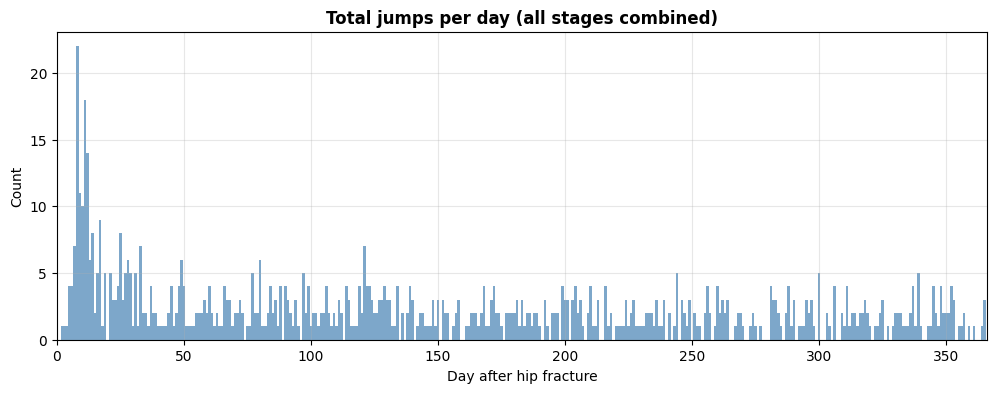

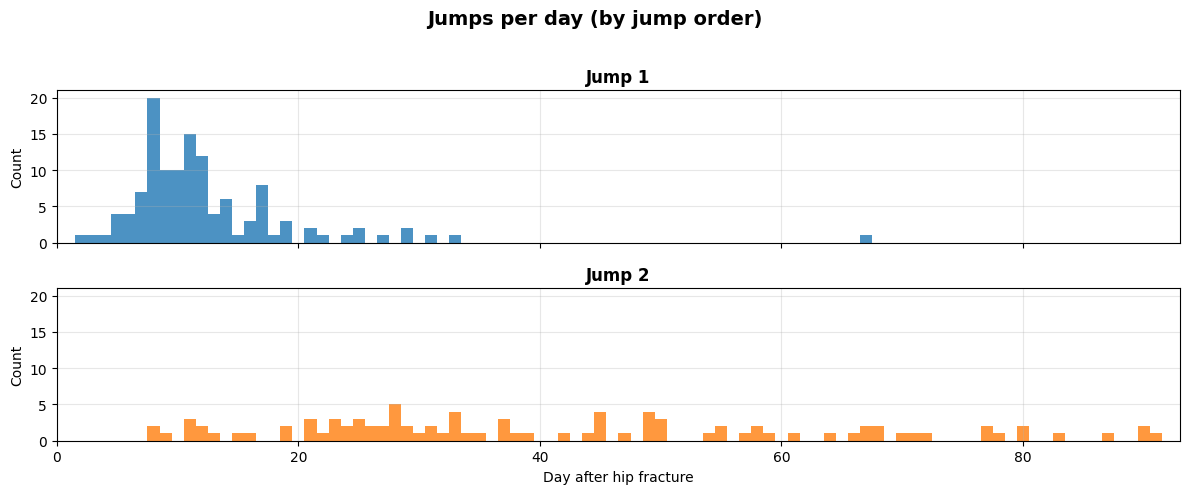

In [ ]:
#jumps per day (total) and separately by order
max_jumps = jump_info_unstable_situation["num_jumps"].max()
days = np.arange(1, 366)


daily_counts = np.zeros_like(days, dtype=int)


order_counts = {f"Jump {i+1}": np.zeros_like(days, dtype=int) for i in range(max_jumps)}

for _, row in jump_info_unstable_situation.iterrows():
    for j, d in enumerate(row["jump_days"]):
        daily_counts[d-1] += 1
        if j < max_jumps:
            order_counts[f"Jump {j+1}"][d-1] += 1


plt.figure(figsize=(12, 4))
plt.bar(days, daily_counts, color="steelblue", alpha=0.7, width=1.0)
plt.title("Total jumps per day (all stages combined)", fontweight="bold")
plt.xlabel("Day after hip fracture")
plt.ylabel("Count")
plt.xlim(0, 366)
plt.grid(alpha=0.3)
plt.show()


#n_orders = min(max_jumps, 5)
n_orders = min(max_jumps, 2)
fig, axes = plt.subplots(n_orders, 1, figsize=(12, 2.5*n_orders), sharex=True, sharey=True)

if n_orders == 1:
    axes = [axes]

colors = plt.cm.tab10.colors

for i, order in enumerate(list(order_counts.keys())[:n_orders]):
    axes[i].bar(days, order_counts[order],
                color=colors[i % len(colors)],
                width=1, alpha=0.8)
    axes[i].set_title(order, fontweight="bold")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Day after hip fracture")
plt.xlim(0, 93)
plt.suptitle("Jumps per day (by jump order)", fontweight="bold", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

***My takeaway:** 1.only the first 2 changes have obvious distribution. 2.Most stage-changing happened durin first 2 month*

In [ ]:
jump_info_unstable_situation.head()

,num_jumps,jump_days,durations,jump_group
0,4,"[10, 45, 101, 107]","[10, 35, 56, 6]",Group 2
2,7,"[22, 58, 79, 92, 121, 134, 183]","[22, 36, 21, 13, 29, 13, 49]",Group 4
4,8,"[8, 49, 123, 124, 139, 213, 226, 236]","[8, 41, 74, 1, 15, 74, 13, 10]",Group 4
8,5,"[19, 33, 112, 119, 173]","[19, 14, 79, 7, 54]",Group 3
13,6,"[10, 55, 58, 90, 98, 177]","[10, 45, 3, 32, 8, 79]",Group 3


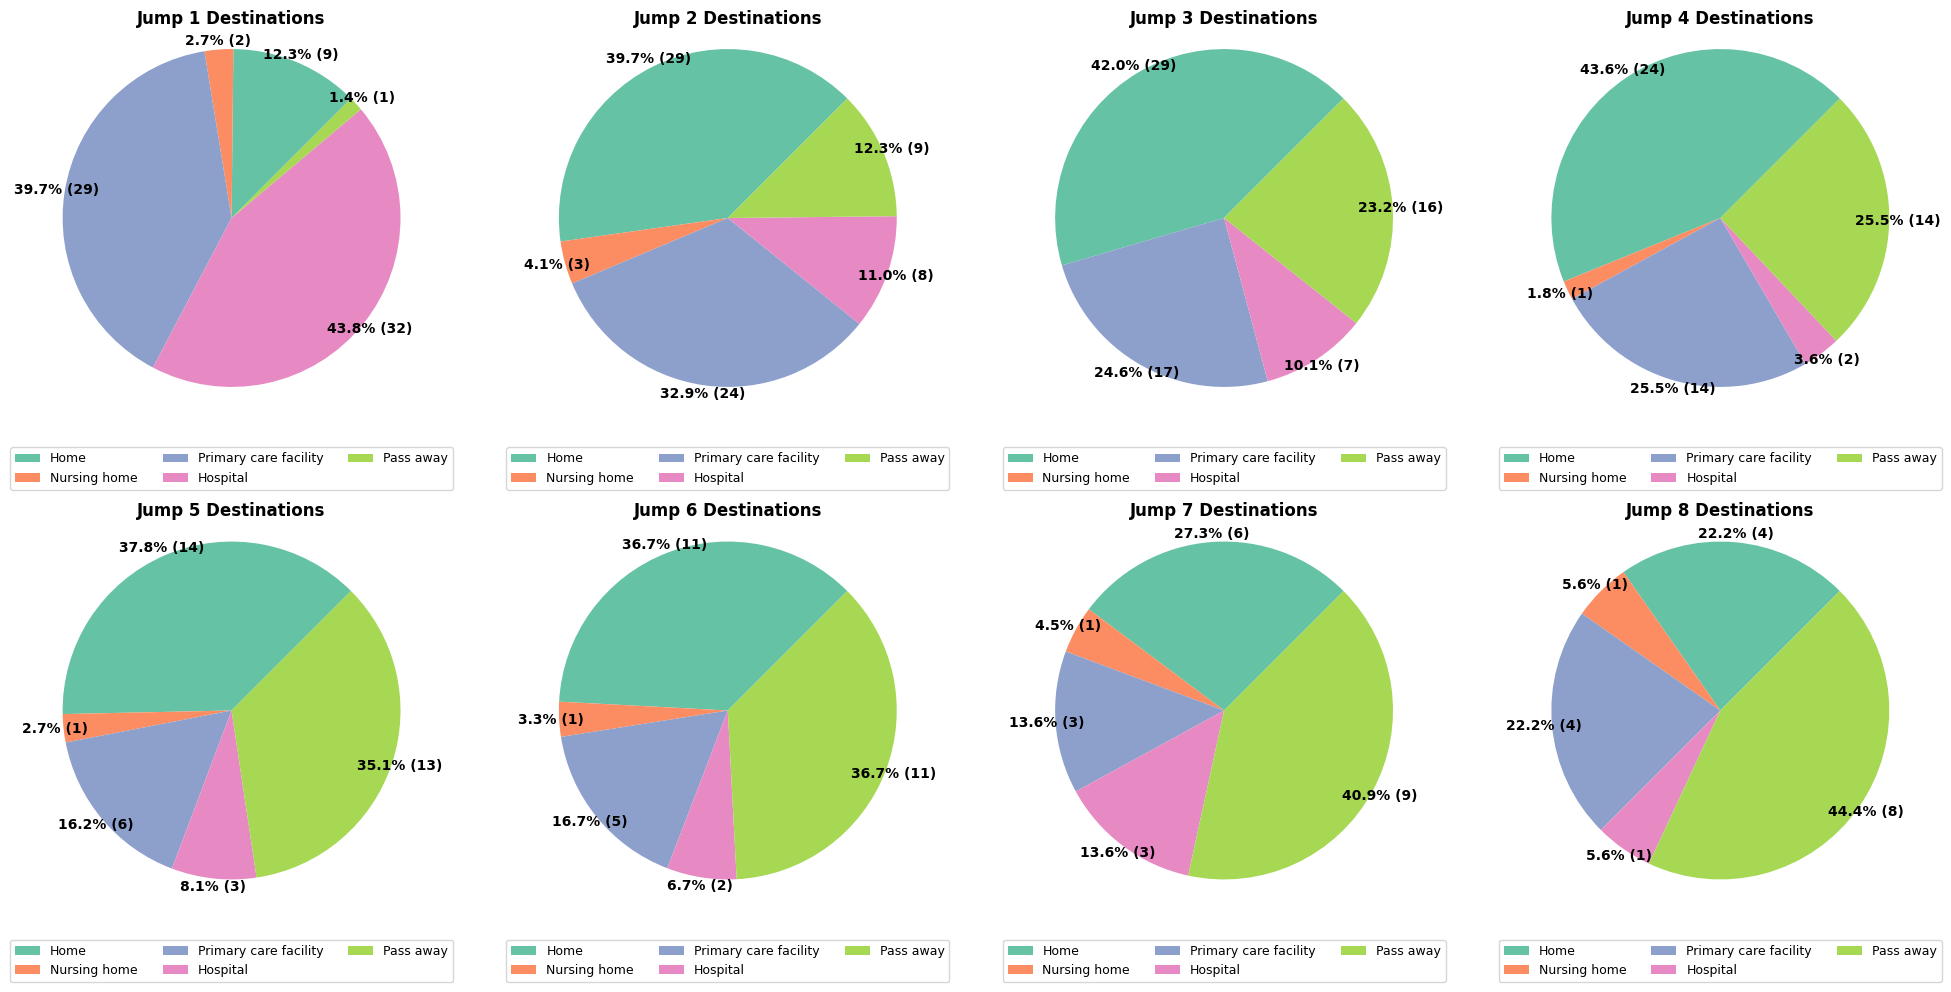

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels_map = {
    0: "Home",
    1: "Nursing home",
    2: "Primary care facility",
    3: "Hospital",
    4: "Pass away"
}

# Columns S1..S365 sorted numerically
S_cols = sorted([c for c in unstable_situation.columns if c.startswith("S")], key=lambda x: int(x[1:]))

# --- Collect destinations by jump order (up to 8) ---
max_jumps = 8
jump_dests = {j: [] for j in range(1, max_jumps+1)}

for idx, row in jump_info_unstable_situation.iterrows():
    if len(row["jump_days"]) == 0 or idx >= len(unstable_situation):
        continue

    patient_row = unstable_situation.iloc[idx]

    for j, jump_day in enumerate(row["jump_days"], start=1):
        if j > max_jumps:
            break
        if 1 <= jump_day <= len(S_cols):
            stage_after = patient_row[S_cols[jump_day-1]]
            jump_dests[j].append(stage_after)

# --- Plot pie charts for jumps 1–8 ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for j in range(1, max_jumps+1):
    dest_list = jump_dests[j]
    ax = axes[j-1]

    if not dest_list:
        ax.set_axis_off()
        ax.set_title(f"Jump {j}\n(no data)")
        continue

    # Count only specific categories
    dest_counts = [
    dest_list.count(0),
    dest_list.count(1),
    dest_list.count(2),
    dest_list.count(3),
    dest_list.count(4)
    ]

    labels = ["Home", "Nursing home", "Primary care facility", "Hospital", "Pass away"]
    colors = sns.color_palette("Set2", n_colors=len(labels))

    wedges, _ = ax.pie(dest_counts, startangle=45, colors=colors, pctdistance=1.15)

    # Add percentages
    for wedge, count in zip(wedges, dest_counts):
        if count > 0:
            ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
            x = np.cos(np.deg2rad(ang)) * 1.05
            y = np.sin(np.deg2rad(ang)) * 1.05
            ax.text(x, y, f"{count/len(dest_list)*100:.1f}% ({count})",
                    ha="center", va="center", fontsize=10, fontweight="bold")

    ax.set_title(f"Jump {j} Destinations", fontsize=12, fontweight="bold")
    ax.axis("equal")
    ax.legend(wedges, labels, loc="upper center", bbox_to_anchor=(0.5, -0.1),
              ncol=3, fontsize=9, frameon=True)

plt.tight_layout()
plt.show()

***My takeaway:** In a fluctuating situation, when the stage changes over 4 times, the risk of death increases.*

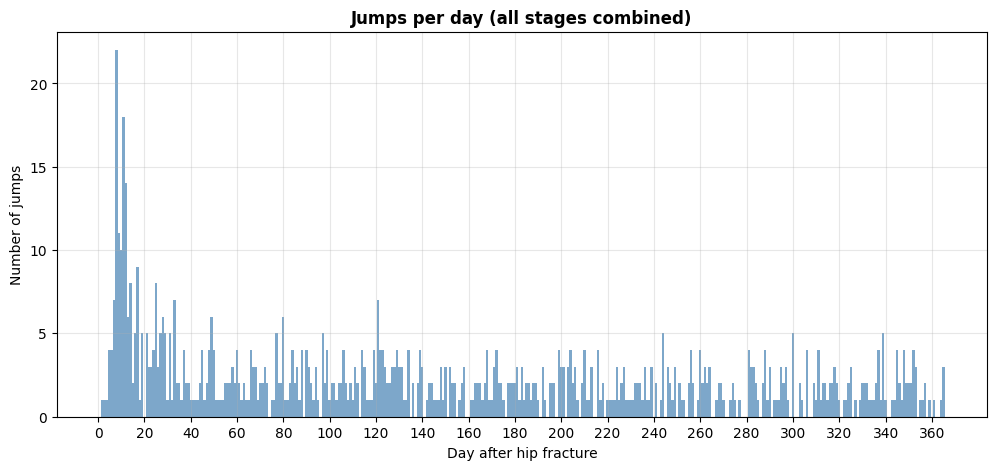

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# --- Count total jumps per day ---
all_jump_days = [day for sublist in jump_info_unstable_situation["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

# --- Bar plot ---
plt.figure(figsize=(12, 5))
plt.bar(days, jump_per_day, color="steelblue", alpha=0.7, width=1.0)

plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Jumps per day (all stages combined)", fontweight="bold")

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 20)
plt.xticks(xticks)

plt.grid(alpha=0.3)
plt.show()

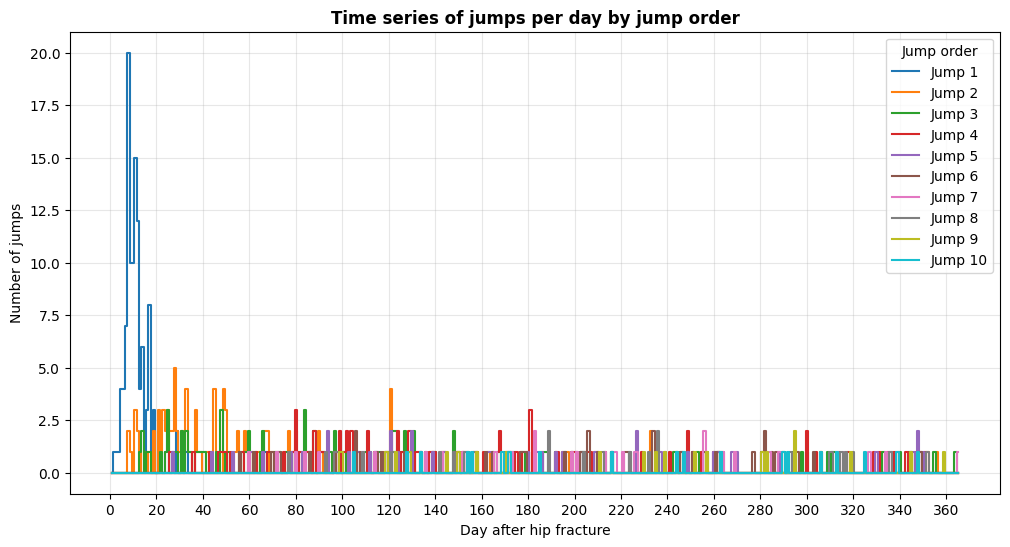

In [ ]:

max_jumps = jump_info_unstable_situation["num_jumps"].max()
days = np.arange(1, 366)


order_counts = {f"Jump {i+1}": np.zeros_like(days, dtype=int) for i in range(max_jumps)}

for _, row in jump_info_unstable_situation.iterrows():
    for j, d in enumerate(row["jump_days"]):
        if j < max_jumps:
            order_counts[f"Jump {j+1}"][d-1] += 1

# --- Plot ---
plt.figure(figsize=(12,6))

colors = plt.cm.tab10.colors
for (order, counts), col in zip(order_counts.items(), colors):
    plt.plot(days, counts, label=order, color=col, drawstyle="steps-mid")

plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day by jump order", fontweight="bold")
plt.xticks(np.arange(0, 366, 20))
plt.grid(alpha=0.3)
plt.legend(title="Jump order")
plt.show()


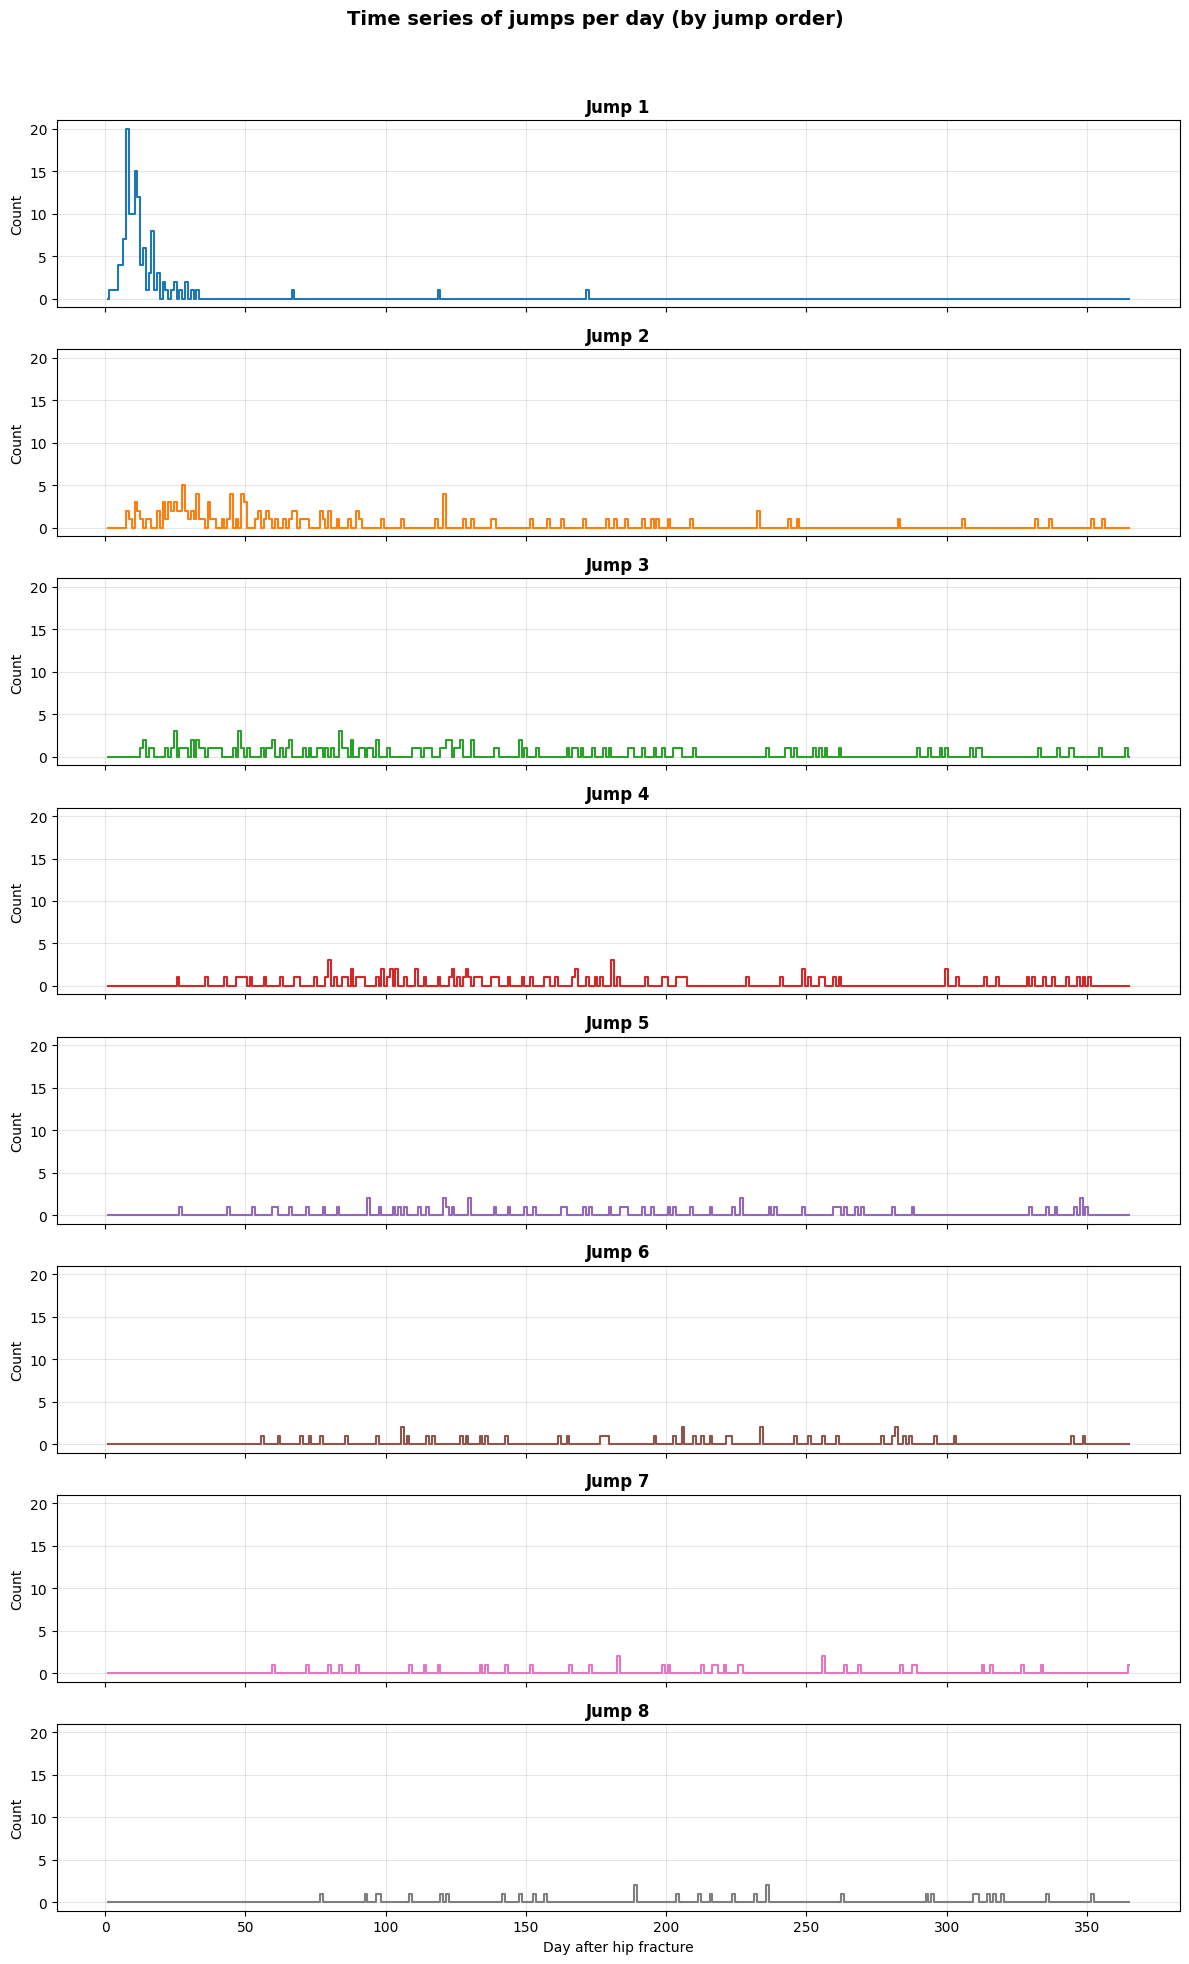

In [ ]:
# --- Count jumps separately by order (1st, 2nd, 3rd, …) ---
max_jumps = jump_info_unstable_situation["num_jumps"].max()
days = np.arange(1, 366)

order_counts = {f"Jump {i+1}": np.zeros_like(days, dtype=int) for i in range(max_jumps)}

for _, row in jump_info_unstable_situation.iterrows():
    for j, d in enumerate(row["jump_days"]):
        if j < max_jumps:
            order_counts[f"Jump {j+1}"][d-1] += 1

# --- Create subplots ---
n_orders = min(max_jumps, 8)
fig, axes = plt.subplots(n_orders, 1, figsize=(12, 2.5*n_orders), sharex=True, sharey=True)


if n_orders == 1:
    axes = [axes]

colors = plt.cm.tab10.colors

for i, order in enumerate(list(order_counts.keys())[:n_orders]):
    axes[i].plot(days, order_counts[order], color=colors[i % len(colors)], drawstyle="steps-mid")
    axes[i].set_title(order, fontweight="bold")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Count")

axes[-1].set_xlabel("Day after hip fracture")

plt.suptitle("Time series of jumps per day (by jump order)", fontweight="bold", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/tmp/ipython-input-3282798811.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-3282798811.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-3282798811.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



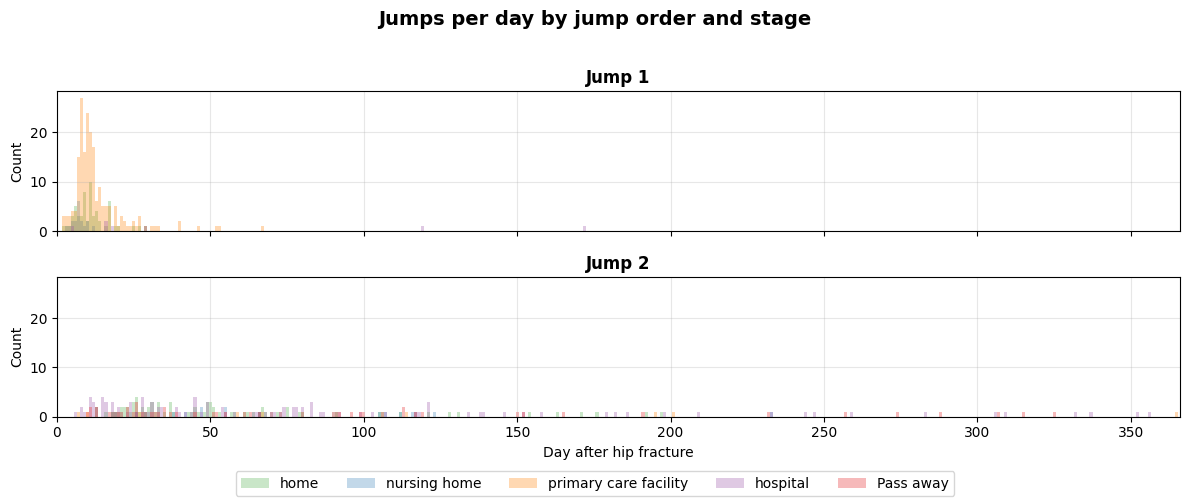

In [ ]:

labels_map = {
    0: "home",
    1: "nursing home",
    2: "primary care facility",
    3: "hospital",
    4: "Pass away"
}
stage_to_num = {v: k for k, v in labels_map.items()}


colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00",
    "hospital": "#984ea3",
    "Pass away": "#e41a1c"
}


S_cols = [c for c in unstable_situation.columns if str(c).startswith("S")]
unstable_numeric = unstable_situation[S_cols].replace(stage_to_num)



def get_jumps_all_changes(row):
    values = row.values.astype(int)
    diffs = np.diff(values)


    jump_days = np.where(diffs != 0)[0] + 2   # +2 because diff shifts index
    num_jumps = len(jump_days)

    # durations between jumps
    durations = []
    if num_jumps >= 1:
        durations.append(jump_days[0])
    if num_jumps > 1:
        for i in range(1, num_jumps):
            durations.append(jump_days[i] - jump_days[i-1])


    jump_stages = [values[day-1] for day in jump_days]
    jump_stages_labels = [labels_map[s] for s in jump_stages]

    return pd.Series(
        [num_jumps, list(zip(jump_days, jump_stages_labels)), durations],
        index=["num_jumps", "jumps", "durations"]
    )


unstable_situation[["num_jumps", "jumps", "durations"]] = unstable_numeric.apply(get_jumps_all_changes, axis=1)



max_jumps = unstable_situation["num_jumps"].max()
days = np.arange(1, 366)
n_orders = min(max_jumps, 2)

order_stage_counts = {
    f"Jump {i+1}": {stage: np.zeros_like(days, dtype=int) for stage in colors_map.keys()}
    for i in range(n_orders)
}

for _, row in unstable_situation.iterrows():
    for j, (day, stage) in enumerate(row["jumps"]):
        if j < n_orders:
            order_stage_counts[f"Jump {j+1}"][stage][day-1] += 1



fig, axes = plt.subplots(n_orders, 1, figsize=(12, 2.5*n_orders), sharex=True, sharey=True)
if n_orders == 1:
    axes = [axes]

bar_width = 1

for i, order in enumerate(list(order_stage_counts.keys())[:n_orders]):
    bottom = np.zeros_like(days)
    for stage, counts in order_stage_counts[order].items():
        axes[i].bar(
            days,
            counts,
            color=colors_map[stage],
            width=bar_width,
            label=stage,
            alpha=0.3
        )
        bottom += counts
    axes[i].set_title(order, fontweight="bold")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Count")
    axes[i].set_xlim(0, 366)

axes[-1].set_xlabel("Day after hip fracture")

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=10, frameon=True)

plt.suptitle("Jumps per day by jump order and stage", fontweight="bold", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


/tmp/ipython-input-3851148759.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



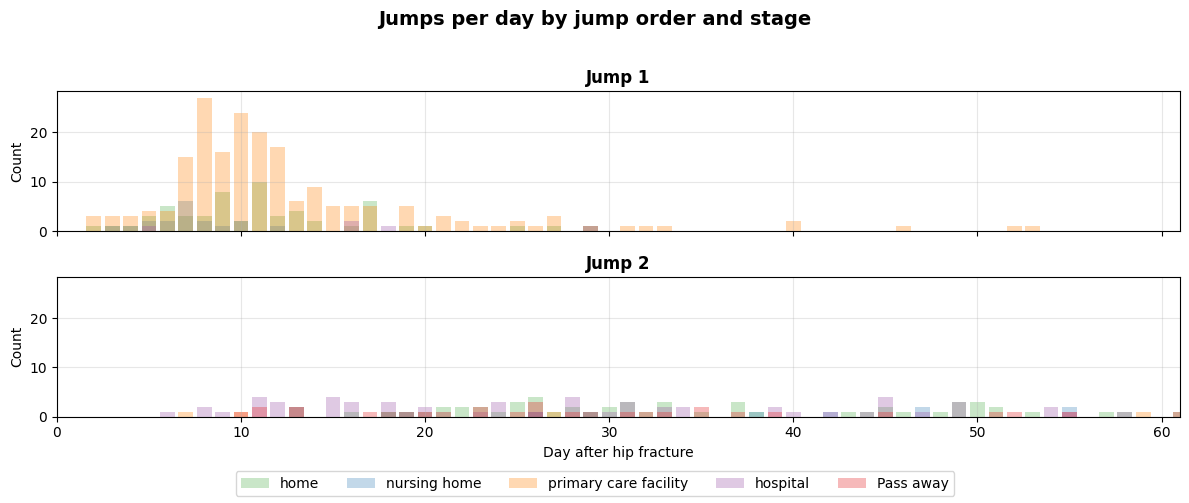

In [ ]:
labels_map = {
    0: "home",
    1: "nursing home",
    2: "primary care facility",
    3: "hospital",
    4: "Pass away"
}
stage_to_num = {v: k for k, v in labels_map.items()}


colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00",
    "hospital": "#984ea3",
    "Pass away": "#e41a1c"
}


S_cols = [c for c in unstable_situation.columns if str(c).startswith("S")]
unstable_numeric = unstable_situation[S_cols].replace(stage_to_num)



def get_jumps_all_changes(row):
    values = row.values.astype(int)
    diffs = np.diff(values)


    jump_days = np.where(diffs != 0)[0] + 2   # +2 because diff shifts index
    num_jumps = len(jump_days)


    durations = []
    if num_jumps >= 1:
        durations.append(jump_days[0])
    if num_jumps > 1:
        for i in range(1, num_jumps):
            durations.append(jump_days[i] - jump_days[i-1])


    jump_stages = [values[day-1] for day in jump_days]
    jump_stages_labels = [labels_map[s] for s in jump_stages]

    return pd.Series(
        [num_jumps, list(zip(jump_days, jump_stages_labels)), durations],
        index=["num_jumps", "jumps", "durations"]
    )



unstable_situation[["num_jumps", "jumps", "durations"]] = unstable_numeric.apply(get_jumps_all_changes, axis=1)



max_jumps = unstable_situation["num_jumps"].max()
days = np.arange(1, 366)
n_orders = min(max_jumps, 2)

order_stage_counts = {
    f"Jump {i+1}": {stage: np.zeros_like(days, dtype=int) for stage in colors_map.keys()}
    for i in range(n_orders)
}

for _, row in unstable_situation.iterrows():
    for j, (day, stage) in enumerate(row["jumps"]):
        if j < n_orders:
            order_stage_counts[f"Jump {j+1}"][stage][day-1] += 1



fig, axes = plt.subplots(n_orders, 1, figsize=(12, 2.5*n_orders), sharex=True, sharey=True)
if n_orders == 1:
    axes = [axes]

bar_width = 0.8

for i, order in enumerate(list(order_stage_counts.keys())[:n_orders]):
    bottom = np.zeros_like(days)
    for stage, counts in order_stage_counts[order].items():
        axes[i].bar(
            days,
            counts,
            color=colors_map[stage],
            width=bar_width,
            label=stage,
            alpha=0.3
        )
        bottom += counts
    axes[i].set_title(order, fontweight="bold")
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Count")
    axes[i].set_xlim(0, 61)

axes[-1].set_xlabel("Day after hip fracture")

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=10, frameon=True)

plt.suptitle("Jumps per day by jump order and stage", fontweight="bold", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


New grouping method:

/tmp/ipython-input-309354288.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




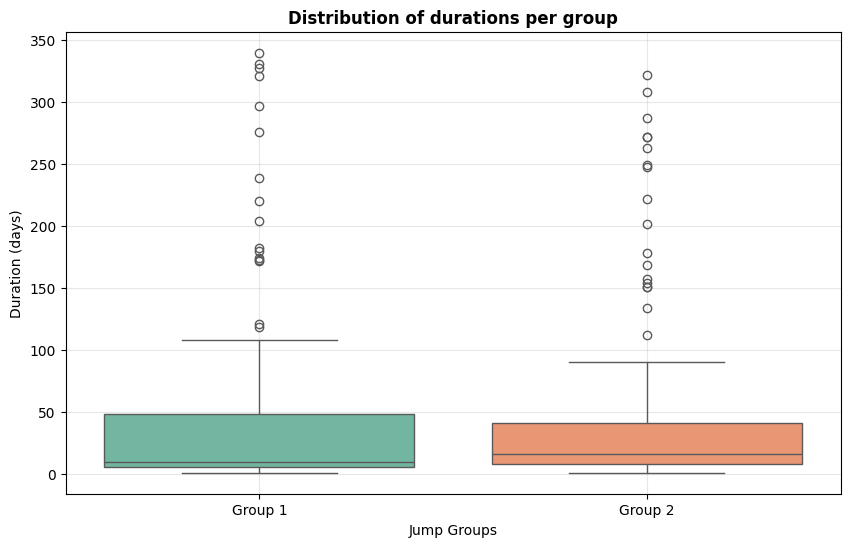

In [ ]:
def categorize_jumps(n):
    if n in [2, 3, 4]:
        return "Group 1"
    else:
        return "Group 2"


jump_info_unstable_situation["jump_group"] = jump_info_unstable_situation["num_jumps"].apply(categorize_jumps)

order = ["Group 1", "Group 2"]


jump_info_unstable_situation["jump_group"] = pd.Categorical(jump_info_unstable_situation["jump_group"], categories=order, ordered=True)


plt.figure(figsize=(10,6))
sns.boxplot(
    data=dur_df,
    x="jump_group",
    y="duration",
    palette="Set2",
    order=order
)

plt.xlabel("Jump Groups")
plt.ylabel("Duration (days)")
plt.title("Distribution of durations per group", fontweight="bold")
plt.grid(alpha=0.3)
plt.show()

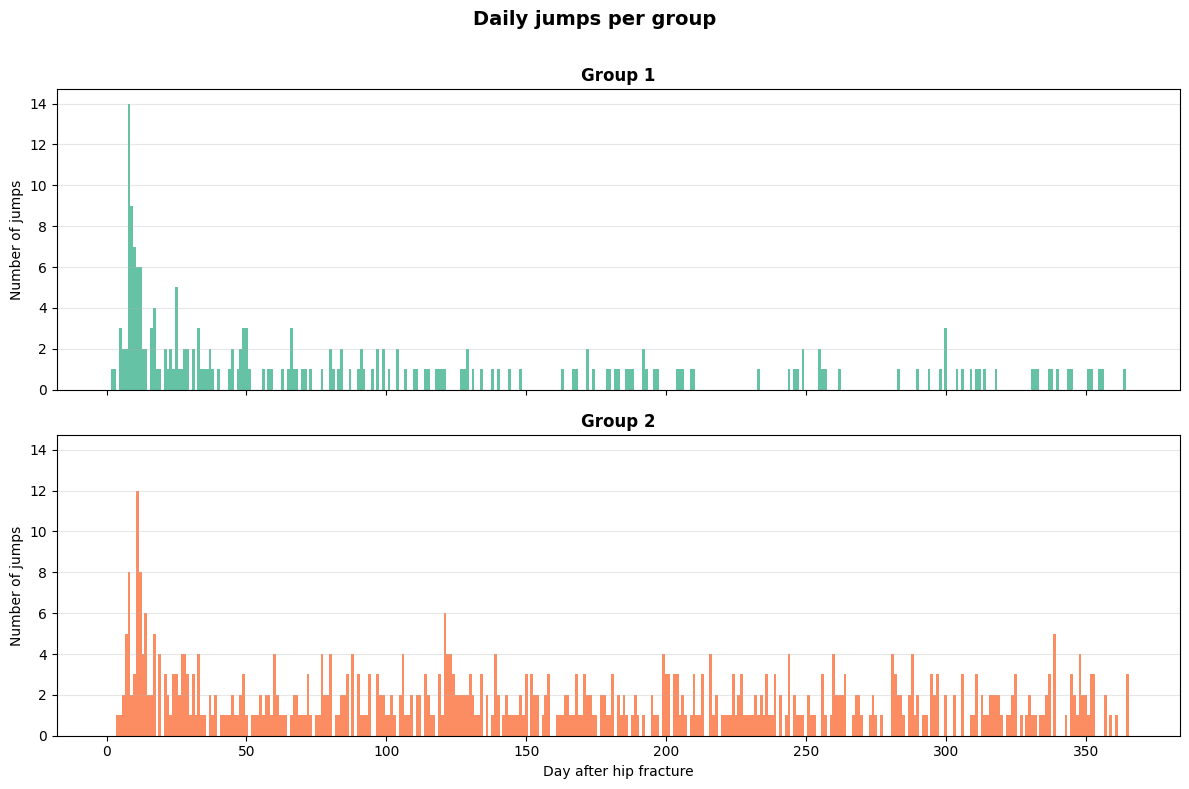

In [ ]:
def categorize_jumps(n):
    if n in [2, 3, 4]:
        return "Group 1"
    else:
        return "Group 2"

jump_info_unstable_situation["jump_group"] = jump_info_unstable_situation["num_jumps"].apply(categorize_jumps)

order = ["Group 1", "Group 2"]
jump_info_unstable_situation["jump_group"] = pd.Categorical(
    jump_info_unstable_situation["jump_group"],
    categories=order,
    ordered=True
)

# per-group jump counts
days = np.arange(1, 366)
group_counts = {g: np.zeros_like(days, dtype=int) for g in order}

for _, row in jump_info_unstable_situation.iterrows():
    g = row["jump_group"]
    for d in row["jump_days"]:
        group_counts[g][d-1] += 1

#bar chart
colors = ["#66c2a5", "#fc8d62"]
fig, axes = plt.subplots(len(order), 1, figsize=(12, 8), sharex=True, sharey=True)

for ax, (g, col) in zip(axes, zip(order, colors)):
    ax.bar(days, group_counts[g], color=col, width=1.0)
    ax.set_title(f"{g}", fontweight="bold")
    ax.set_ylabel("Number of jumps")
    ax.grid(alpha=0.3, axis="y")

axes[-1].set_xlabel("Day after hip fracture")

fig.suptitle("Daily jumps per group", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

/tmp/ipython-input-4179095942.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



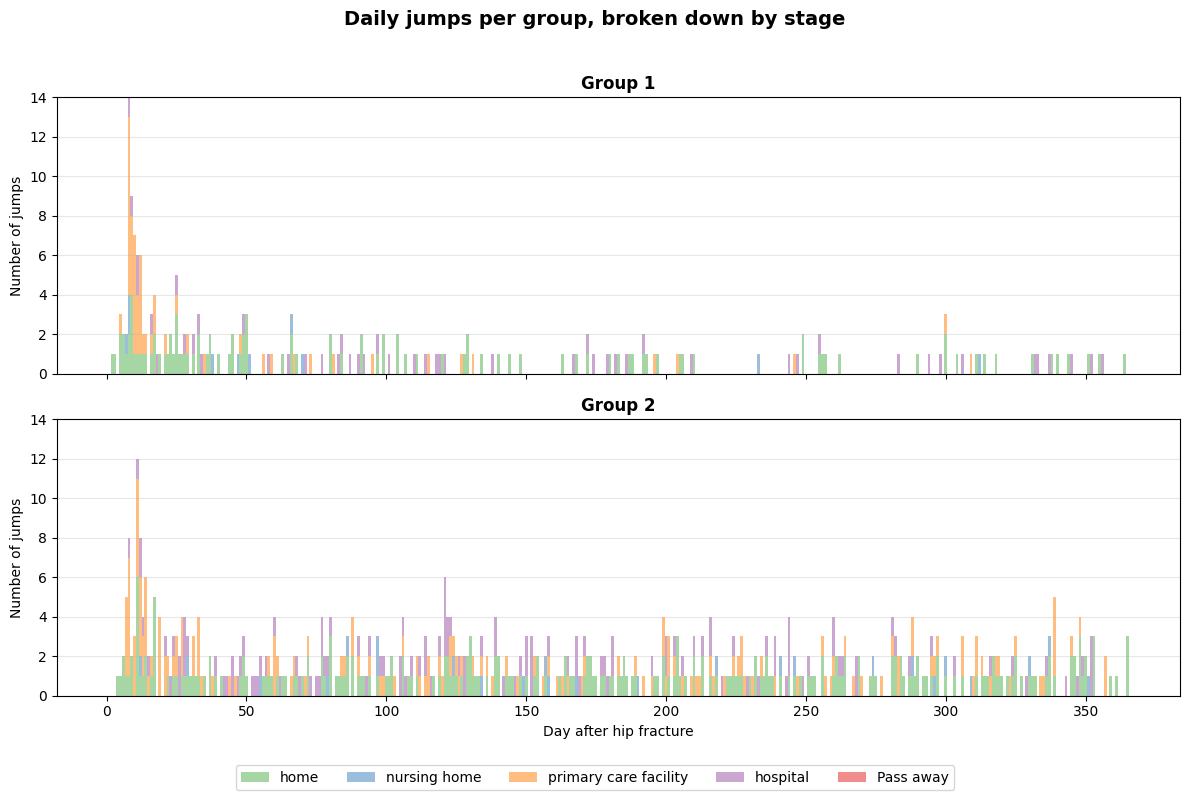

In [ ]:

def categorize_jumps(n):
    if n in [2, 3, 4]:
        return "Group 1"
    else:
        return "Group 2"

jump_info_unstable_situation["jump_group"] = jump_info_unstable_situation["num_jumps"].apply(categorize_jumps)

order_groups = ["Group 1", "Group 2"]
jump_info_unstable_situation["jump_group"] = pd.Categorical(
    jump_info_unstable_situation["jump_group"],
    categories=order_groups,
    ordered=True
)

#per-group, per-stage counts
days = np.arange(1, 366)
colors_map = {
    "home": "#4daf4a",
    "nursing home": "#377eb8",
    "primary care facility": "#ff7f00",
    "hospital": "#984ea3",
    "Pass away": "#e41a1c"
}


S_cols = [c for c in unstable_situation.columns if str(c).startswith("S")]
stage_to_num = {v: k for k, v in {
    0: "home",
    1: "nursing home",
    2: "primary care facility",
    3: "hospital",
    4: "Pass away"
}.items()}
unstable_numeric = unstable_situation[S_cols].replace(stage_to_num)

def get_jumps_all_changes(row):
    values = row.values.astype(int)
    diffs = np.diff(values)
    jump_days = np.where(diffs != 0)[0] + 2
    jump_stages = [values[day-1] for day in jump_days]
    jump_stages_labels = [labels_map[s] for s in jump_stages]
    return pd.Series([list(zip(jump_days, jump_stages_labels))], index=["jumps"])

unstable_situation[["jumps"]] = unstable_numeric.apply(get_jumps_all_changes, axis=1)

#  counts per group and per stage
group_stage_counts = {
    g: {stage: np.zeros_like(days, dtype=int) for stage in colors_map.keys()}
    for g in order_groups
}


for idx, row in jump_info_unstable_situation.iterrows():
    g = row["jump_group"]
    patient_jumps = unstable_situation.loc[unstable_situation.index == row.name, "jumps"].values[0]
    for day, stage in patient_jumps:
        group_stage_counts[g][stage][day-1] += 1

fig, axes = plt.subplots(len(order_groups), 1, figsize=(12, 8), sharex=True, sharey=True)

bar_width = 1
for ax, g in zip(axes, order_groups):
    bottom = np.zeros_like(days)
    for stage, counts in group_stage_counts[g].items():
        ax.bar(days, counts, color=colors_map[stage], width=bar_width, bottom=bottom, label=stage, alpha=0.5)
        bottom += counts
    ax.set_title(g, fontweight="bold")
    ax.set_ylabel("Number of jumps")
    ax.grid(alpha=0.3, axis="y")

axes[-1].set_xlabel("Day after hip fracture")

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=10, frameon=True)

plt.suptitle("Daily jumps per group, broken down by stage", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

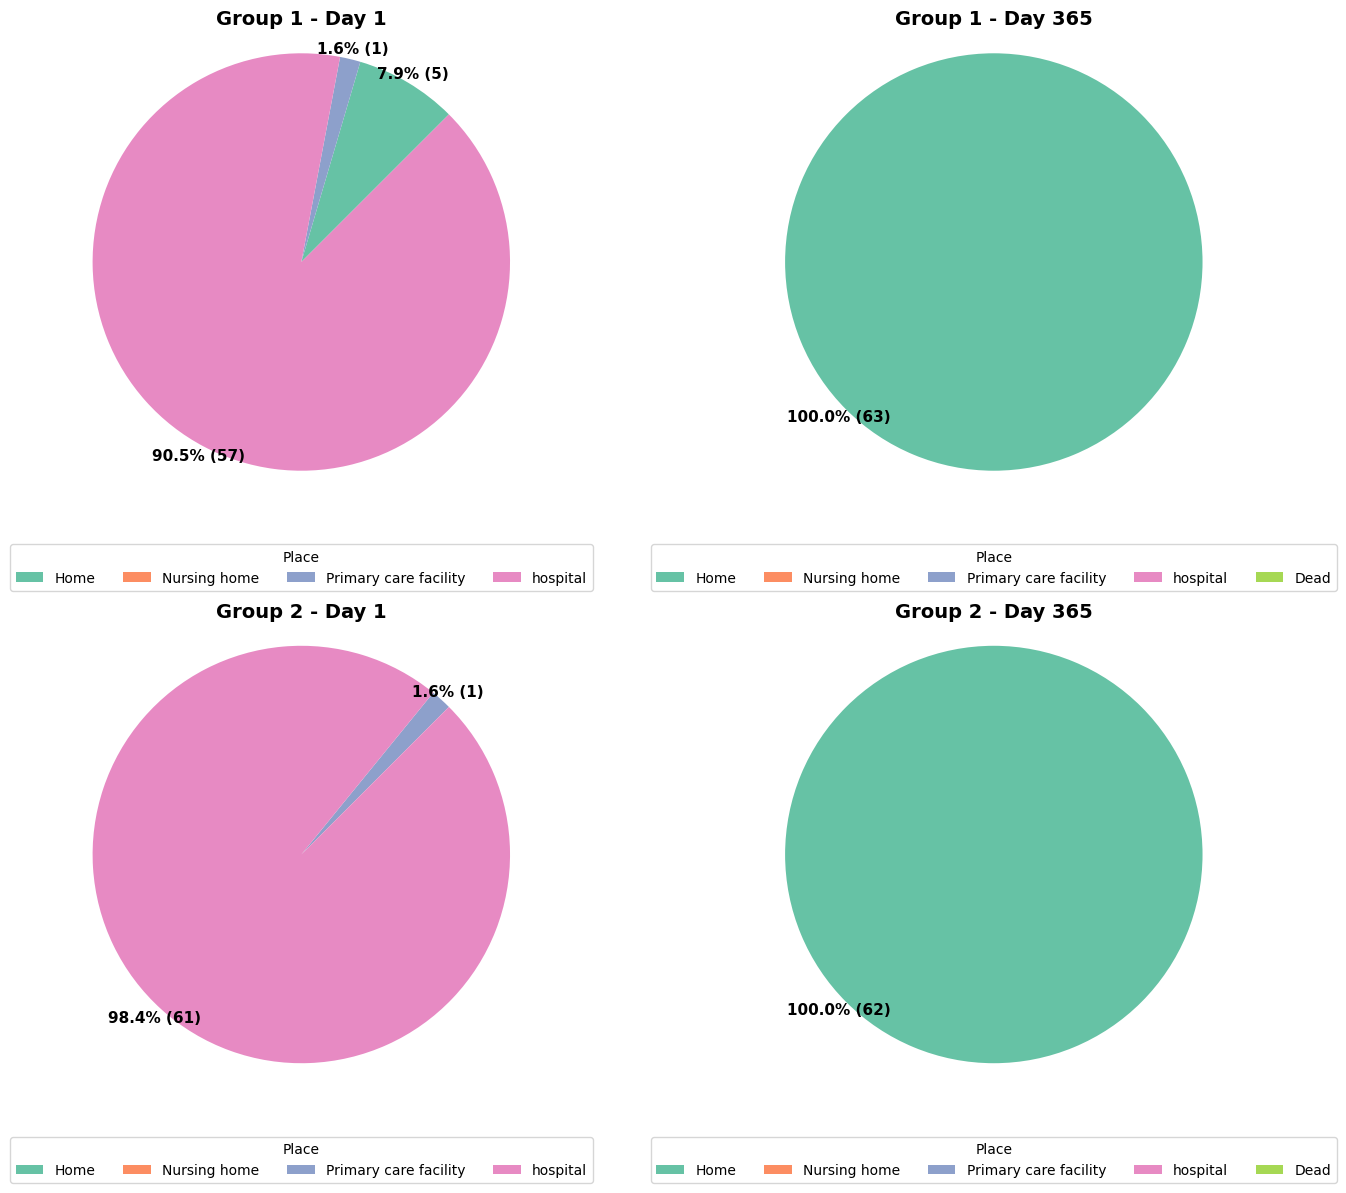

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Merge group info into unstable_situation
df = unstable_situation.copy()
df = df.merge(
    jump_info_unstable_situation[["jump_group"]],
    left_index=True,
    right_index=True,
    how="left"
)

groups = ["Group 1", "Group 2"]
days = ["S1", "S365"]
labels_day1 = ["Home", "Nursing home", "Primary care facility", "hospital"]
labels_day365 = ["Home", "Nursing home", "Primary care facility", "hospital", "Dead"]


fig, axes = plt.subplots(2, 2, figsize=(14,12))
axes = axes.flatten()

for i, (g, day) in enumerate([(g, d) for g in groups for d in days]):
    group_df = df[df["jump_group"]==g]

    if day == "S1":
        labels = labels_day1
        sizes = [
            group_df[group_df[day]==0].shape[0],
            group_df[group_df[day]==1].shape[0],
            group_df[group_df[day]==2].shape[0],
            group_df[group_df[day]==3].shape[0]
        ]
        colors = sns.color_palette("Set2", n_colors=len(labels))
    else:
        labels = labels_day365
        sizes = [
            group_df[group_df[day]==0].shape[0],
            group_df[group_df[day]==1].shape[0],
            group_df[group_df[day]==2].shape[0],
            group_df[group_df[day]==3].shape[0],
            group_df[group_df[day]==4].shape[0]
        ]
        colors = sns.color_palette("Set2", n_colors=len(labels))

    ax = axes[i]
    wedges, texts = ax.pie(
        sizes,
        labels=None,
        startangle=45,
        colors=colors,
        pctdistance=1.15
    )

    for wedge, size in zip(wedges, sizes):
        if size > 0:
            ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
            x = np.cos(np.deg2rad(ang)) * 1.05
            y = np.sin(np.deg2rad(ang)) * 1.05
            ax.text(
                x, y,
                f"{size/sum(sizes)*100:.1f}% ({size})",
                ha="center", va="center",
                fontsize=11, fontweight="bold", color="black"
            )

    ax.set_title(f"{g} - {'Day 1' if day=='S1' else 'Day 365'}", fontsize=14, fontweight="bold")
    ax.axis("equal")
    ax.legend(wedges, labels, title="Place", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=len(labels))

plt.tight_layout()
plt.show()


**Main Result:** Patients who returned home after surgery experienced more than four stage changes. Moreover, the mortality rate increased with the number of stage changes. In contrast, patients with fewer than four changes in their situation were more likely to return home.

In [ ]:
'''labels_map = {
    0: "Home",
    1: "Nursing home",
    2: "Primary care facility",
    3: "Hospital",
    4: "Pass away"
}


S_cols = sorted([c for c in unstable_situation.columns if c.startswith("S")], key=lambda x: int(x[1:]))

# Merge  group info
df = unstable_situation.copy()
df = df.merge(jump_info_unstable_situation[["jump_group"]], left_index=True, right_index=True, how="left")

groups = ["Group 1", "Group 2"]
max_jumps = 8


jump_dests_group = {g: {j: [] for j in range(1, max_jumps+1)} for g in groups}

for idx, row in jump_info_unstable_situation.iterrows():
    g = row["jump_group"]
    if g not in groups:
        continue
    if len(row["jump_days"]) == 0 or idx >= len(df):
        continue

    patient_row = df.iloc[idx]

    for j, jump_day in enumerate(row["jump_days"], start=1):
        if j > max_jumps:
            break
        if 1 <= jump_day <= len(S_cols):
            stage_after = patient_row[S_cols[jump_day-1]]
            jump_dests_group[g][j].append(stage_after)


for g in groups:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for j in range(1, max_jumps+1):
        dest_list = jump_dests_group[g][j]
        ax = axes[j-1]

        if not dest_list:
            ax.set_axis_off()
            ax.set_title(f"Jump {j}\n(no data)")
            continue


        dest_counts = [
            dest_list.count(0),
            dest_list.count(1),
            dest_list.count(2),
            dest_list.count(3),
            dest_list.count(4)
        ]

        labels = ["Home", "Nursing home", "Primary care facility", "Hospital", "Pass away"]
        colors = sns.color_palette("Set2", n_colors=len(labels))

        wedges, _ = ax.pie(dest_counts, startangle=45, colors=colors, pctdistance=1.15)


        for wedge, count in zip(wedges, dest_counts):
            if count > 0:
                ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
                x = np.cos(np.deg2rad(ang)) * 1.05
                y = np.sin(np.deg2rad(ang)) * 1.05
                ax.text(x, y, f"{count/len(dest_list)*100:.1f}% ({count})", ha="center", va="center", fontsize=10, fontweight="bold")

        ax.set_title(f"Jump {j} Destinations", fontsize=12, fontweight="bold")
        ax.axis("equal")
        ax.legend(wedges, labels, loc="upper center", bbox_to_anchor=(0.5, -0.1),
                  ncol=3, fontsize=9, frameon=True)

    plt.suptitle(f"{g} - Jump Destinations", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()'''

'labels_map = {\n    0: "Home",\n    1: "Nursing home",\n    2: "Primary care facility",\n    3: "Hospital",\n    4: "Pass away"\n}\n\n\nS_cols = sorted([c for c in unstable_situation.columns if c.startswith("S")], key=lambda x: int(x[1:]))\n\n# Merge  group info\ndf = unstable_situation.copy()\ndf = df.merge(jump_info_unstable_situation[["jump_group"]], left_index=True, right_index=True, how="left")\n\ngroups = ["Group 1", "Group 2"]\nmax_jumps = 8\n\n\njump_dests_group = {g: {j: [] for j in range(1, max_jumps+1)} for g in groups}\n\nfor idx, row in jump_info_unstable_situation.iterrows():\n    g = row["jump_group"]\n    if g not in groups:\n        continue\n    if len(row["jump_days"]) == 0 or idx >= len(df):\n        continue\n\n    patient_row = df.iloc[idx]\n\n    for j, jump_day in enumerate(row["jump_days"], start=1):\n        if j > max_jumps:\n            break\n        if 1 <= jump_day <= len(S_cols):\n            stage_after = patient_row[S_cols[jump_day-1]]\n            ju

In [2]:
df = pd.read_csv('star.csv')
df.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S356,S357,S358,S359,S360,S361,S362,S363,S364,S365
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def get_jumps_all_changes(row):
    values = row.values
    diffs = np.diff(values)


    jump_days = np.where(diffs != 0)[0] + 2
    num_jumps = len(jump_days)

    #durations
    durations = []
    if num_jumps >= 1:
        durations.append(jump_days[0])
    if num_jumps > 1:
        for i in range(1, num_jumps):
            durations.append(jump_days[i] - jump_days[i-1])

    return pd.Series(
        [num_jumps, jump_days, durations],
        index=["num_jumps", "jump_days", "durations"]
    )


jump_info_df = (
    df
    .drop(["ID"], axis=1)
    .apply(get_jumps_all_changes, axis=1)
)


print(jump_info_df.head())

   num_jumps                              jump_days  \
0          4                     [10, 45, 101, 107]   
1          1                                    [8]   
2          7        [22, 58, 79, 92, 121, 134, 183]   
3          2                               [15, 29]   
4          8  [8, 49, 123, 124, 139, 213, 226, 236]   

                        durations  
0                 [10, 35, 56, 6]  
1                             [8]  
2    [22, 36, 21, 13, 29, 13, 49]  
3                        [15, 14]  
4  [8, 41, 74, 1, 15, 74, 13, 10]  


## 1. KMeans

Best k by silhouette: 3 Score: 0.5810452275322329


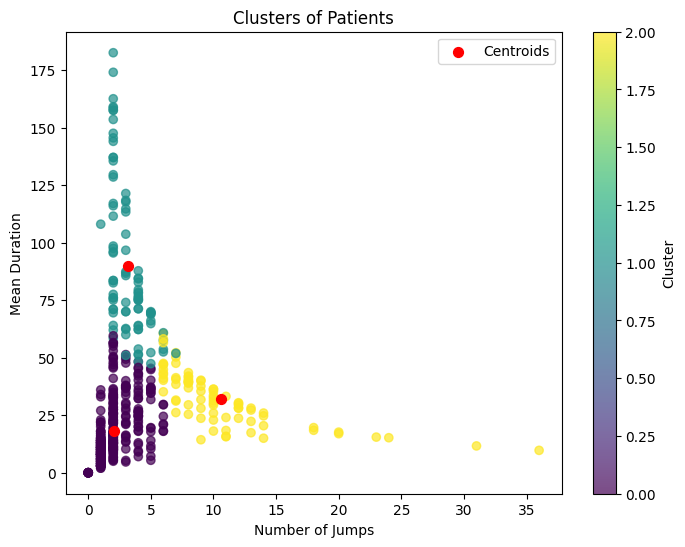

Silhouette Score: 0.5810452275322329
Davies-Bouldin Score: 0.7405855974710015


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  Features
features = pd.DataFrame({
    "num_jumps": jump_info_df["num_jumps"],
    "mean_duration": jump_info_df["durations"].apply(lambda x: np.mean(x) if len(x) > 0 else 0),
    "std_duration": jump_info_df["durations"].apply(lambda x: np.std(x) if len(x) > 0 else 0)
})


X = StandardScaler().fit_transform(features)

#optimize k
sil_scores = {}
for k in range(2, 6):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels_test = kmeans_test.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels_test)

best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k, "Score:", sil_scores[best_k])

# best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X)
features["cluster"] = labels

#Scatter plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(features["num_jumps"], features["mean_duration"],
                      c=features["cluster"], cmap="viridis", alpha=0.7)

# Centroids
centroids = kmeans.cluster_centers_
centroids_unscaled = StandardScaler().fit(features[["num_jumps","mean_duration","std_duration"]]).inverse_transform(centroids)

plt.scatter(centroids_unscaled[:,0], centroids_unscaled[:,1],
            c="red", marker="o", s=50, label="Centroids")

plt.xlabel("Number of Jumps")
plt.ylabel("Mean Duration")
plt.title("Clusters of Patients")
plt.legend()
plt.colorbar(scatter, label="Cluster")
plt.show()

# evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(X, features["cluster"])
print("Silhouette Score:", sil_score)

db_score = davies_bouldin_score(X, features["cluster"])
print("Davies-Bouldin Score:", db_score)


In [5]:
features["cluster"].value_counts()

,count
cluster,
0,347
1,90
2,79


The boundaries between the clusters are not always distinct, and some clusters overlap.

It shows our cluster are similar to each other

K-Medoids + Jaccard / Levenshtein

In [6]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2177964 sha256=2ecfa508c0d618d9a71eca4bd252c5e5a63f8db4530297f7dc27b5066dae0b4f
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [7]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.4 MB/s eta 0:00:00


In [8]:
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=e04ada930cba5952468e794c29ac77e04fafb325dd3312a65a073f1e4bd5fc9b
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


Silhouette Scores: {2: np.float64(0.5558844517652473), 3: np.float64(0.52077245895246), 4: np.float64(0.31881484102477176), 5: np.float64(0.2210600857926034), 6: np.float64(0.23165500854118098), 7: np.float64(0.23761774685883214)}
Best number of clusters: 2, with silhouette=0.5559


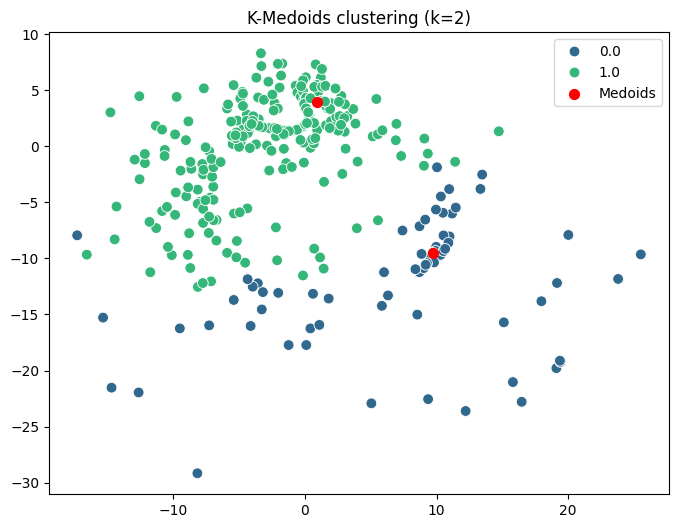

cluster
1.0    444
0.0     72
Name: count, dtype: int64


In [18]:
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
dist_matrix = squareform(pdist(X, metric='euclidean'))


sil_scores = {}
best_score = -1
best_k = None
best_labels = None
best_medoids = None

for k in range(2, 8):
    initial_medoids = list(range(k))

    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()


    labels = np.zeros(len(dist_matrix))
    for cluster_id, points in enumerate(clusters):
        for p in points:
            labels[p] = cluster_id


    sil = silhouette_score(dist_matrix, labels, metric="precomputed")
    sil_scores[k] = sil

    if sil > best_score:
        best_score = sil
        best_k = k
        best_labels = labels
        best_medoids = medoids

print("Silhouette Scores:", sil_scores)
print(f"Best number of clusters: {best_k}, with silhouette={best_score:.4f}")


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
X_2d = mds.fit_transform(dist_matrix)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=best_labels, palette="viridis", s=60)
plt.scatter(X_2d[best_medoids,0], X_2d[best_medoids,1], c="red", marker="o", s=50, label="Medoids")
plt.title(f"K-Medoids clustering (k={best_k})")
plt.legend()
plt.show()


summary = pd.DataFrame({"cluster": best_labels})
print(summary["cluster"].value_counts())

Symbolic Aggregate Approximation (SAX) + k-medoids

/usr/local/lib/python3.12/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 

Best k: 2
Best silhouette score: 0.5558844517652473


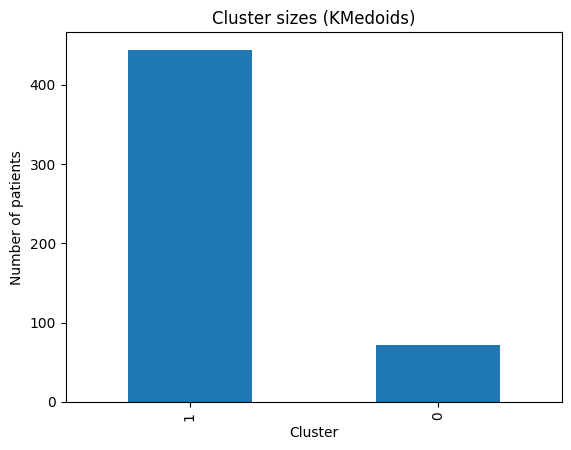

In [10]:
from pyts.approximation import SymbolicAggregateApproximation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric


X = df.drop("ID", axis=1).values

# SAX
sax = SymbolicAggregateApproximation(n_bins=5, strategy="quantile")
X_sax = sax.fit_transform(X)

# Encoding
encoder = LabelEncoder()
X_num = np.array([encoder.fit_transform(row) for row in X_sax])

# Kmedoids
X = X_num

metric = distance_metric(type_metric.EUCLIDEAN)

sil_scores = {}
best_score = -1
best_k = None
best_labels = None
best_medoids = None

for k in range(2, 8):

    initial_medoids = list(range(k))


    kmedoids_instance = kmedoids(X.tolist(), initial_medoids, data_type='points', metric=metric)
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()


    labels = np.zeros(len(X), dtype=int)
    for cluster_id, points in enumerate(clusters):
        for p in points:
            labels[p] = cluster_id


    sil = silhouette_score(X, labels)
    sil_scores[k] = sil

    if sil > best_score:
        best_score = sil
        best_k = k
        best_labels = labels
        best_medoids = medoids

print("Best k:", best_k)
print("Best silhouette score:", best_score)


pd.Series(best_labels).value_counts().plot(kind="bar")
plt.title("Cluster sizes (KMedoids)")
plt.xlabel("Cluster")
plt.ylabel("Number of patients")
plt.show()

In [12]:
from sklearn.decomposition import PCA

/tmp/ipython-input-2877824994.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:,0], X_2d[:,1], c=best_labels, cmap="tab10", alpha=0.7)


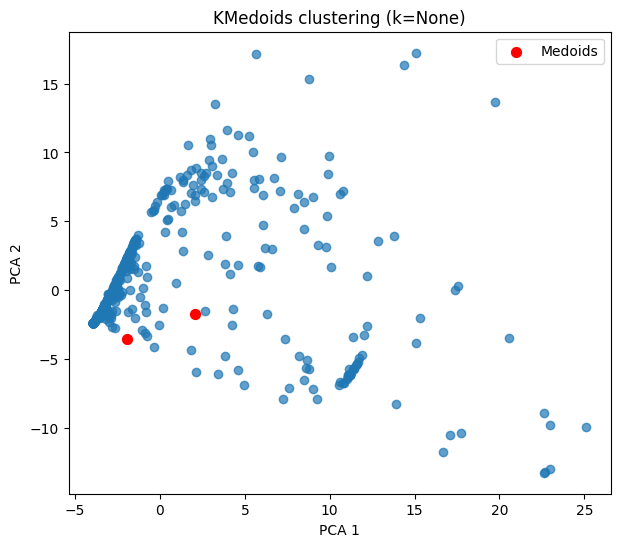

In [13]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=best_labels, cmap="tab10", alpha=0.7)
plt.scatter(X_2d[best_medoids,0], X_2d[best_medoids,1],
            c="red", marker="o", s=50, label="Medoids")
plt.title(f"KMedoids clustering (k={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()